</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

In [1]:
filename_version='2dot10'

In [2]:
import sys
sys.path.append("/Users/pauljacob/Library/Python/3.8/lib/python/site-packages")

In [3]:
#file structure
!pip3 install cookiecutter

#general
!pip3 install --upgrade pip
!pip3 install ipython-autotime --quiet


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
%load_ext autotime

time: 195 µs (started: 2022-10-29 06:12:36 -07:00)


## Import Libraries

In [5]:
#get libraries
import pandas as pd
import os
import numpy as np
#from functools import reduce


#get visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from io import StringIO

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

#ML preprocessing
from sklearn.preprocessing import StandardScaler

#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import __version__ as sklearn_version
import datetime
#from sklearn.pipeline import make_pipeline

#get ML metric functions
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

time: 1.44 s (started: 2022-10-29 06:12:36 -07:00)


In [6]:
#initialize notebook
initialize_custom_notebook_settings()

time: 2.62 ms (started: 2022-10-29 06:12:37 -07:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [7]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))

time: 38.2 ms (started: 2022-10-29 06:12:37 -07:00)


<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [8]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})



#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)

del column_name_age_value_dict, column_name_age_value_list, column_name_age_value_list_cleaned_up


#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]

del column_name_list_not_toCoupon_GEQ5min


#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)

del column_name_Bar_value_dict, column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up, column_name_list_same_unique_values


#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]

del column_name_list_not_direction_same

#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})



#dealing with missing values:
    #solution1: fill in missing values with 'no response' or 'unknown'
    #solution2: fillna with mode of column
    #solution3: use other features to predict what NaN values of occurences per month variables
    #solution4: drop the rows that have null values

#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')
p(df)

(12684, 24)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,1,1,1,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0


time: 86.9 ms (started: 2022-10-29 06:12:37 -07:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [9]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than $12500':6250, '$12500 - $24999':18749.5, '$25000 - $37499':31249.5, '$37500 - $49999':43749.5, '$50000 - $62499':56249.5, '$62500 - $74999':68749.5, '$75000 - $87499':81249.5, '$87500 - $99999':93749.5,'$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

del expiration_category_representative_numeric_encoding, time_category_representative_numeric_encoding, age_category_representative_numeric_encoding, income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

del category_representative_numeric_encoding_dictionary, 

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

del column_name_dictionary_category_representative_numeric_encoding, column_name_list_category_representative_numeric_encoding, category_representative_numeric_encoding_key_list, category_representative_numeric_encoding_substring

#p(df_category_representative_numeric_encoding)

time: 24.3 ms (started: 2022-10-29 06:12:38 -07:00)


## Get Binary Encoding for Features: gender, expiration

In [10]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

del gender_binary_encoding, expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)

del binary_encoding_dictionary


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

del column_name_dictionary_binary_encoding, column_name_list_binary_encoding, binary_encoding_key_list, binary_encoding_substring

#p(df_binary_encoding)

time: 10.6 ms (started: 2022-10-29 06:12:38 -07:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [11]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than $12500':1, '$12500 - $24999':2, '$25000 - $37499':3, '$37500 - $49999':4, '$50000 - $62499':5, '$62500 - $74999':6, '$75000 - $87499':7, '$87500 - $99999':8, '$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

del coupon_venue_type_ordinal_integer_encoding, education_ordinal_integer_encoding, income_ordinal_integer_encoding, age_ordinal_integer_encoding, time_ordinal_integer_encoding, temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

del ordinal_integer_encoding_dictionary

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

del column_name_dictionary_ordinal_integer_encoding, column_name_list_ordinal_integer_encoding, ordinal_integer_encoding_key_list, ordinal_integer_encoding_substring

#p(df_ordinal_integer_encoding)

time: 34.2 ms (started: 2022-10-29 06:12:38 -07:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [12]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


yes_response_ordinal_integer_encoding_dictionary=bar_yes_response_ordinal_integer_encoding|coffeehouse_yes_response_ordinal_integer_encoding|carryaway_yes_response_ordinal_integer_encoding|restaurantlessthan20_yes_response_ordinal_integer_encoding|restaurant20to50_yes_response_ordinal_integer_encoding

del bar_yes_response_ordinal_integer_encoding, coffeehouse_yes_response_ordinal_integer_encoding, carryaway_yes_response_ordinal_integer_encoding, restaurantlessthan20_yes_response_ordinal_integer_encoding, restaurant20to50_yes_response_ordinal_integer_encoding

yes_response_ordinal_integer_encoding_key_list=list(yes_response_ordinal_integer_encoding_dictionary.keys())

df_yes_response_ordinal_integer_encoding = df.loc[:, yes_response_ordinal_integer_encoding_key_list].replace(yes_response_ordinal_integer_encoding_dictionary)

del yes_response_ordinal_integer_encoding_dictionary

#rename columns
yes_response_ordinal_integer_encoding_substring='_yes_response_ordinal_integer_encoding'
column_name_list_yes_response_ordinal_integer_encoding=[str(column_name) + yes_response_ordinal_integer_encoding_substring for column_name in yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_yes_response_ordinal_integer_encoding=dict(zip(yes_response_ordinal_integer_encoding_key_list, column_name_list_yes_response_ordinal_integer_encoding))
df_yes_response_ordinal_integer_encoding = df_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_yes_response_ordinal_integer_encoding)

del column_name_dictionary_yes_response_ordinal_integer_encoding, yes_response_ordinal_integer_encoding_key_list, yes_response_ordinal_integer_encoding_substring, column_name_list_yes_response_ordinal_integer_encoding

#p(df_yes_response_ordinal_integer_encoding)

time: 33.9 ms (started: 2022-10-29 06:12:38 -07:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [13]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

no_response_indicator_variable_dictionary=bar_no_response_indicator_variable|coffeehouse_no_response_indicator_variable|carryaway_no_response_indicator_variable|restaurantlessthan20_no_response_indicator_variable|restaurant20to50_no_response_indicator_variable

del bar_no_response_indicator_variable, coffeehouse_no_response_indicator_variable, carryaway_no_response_indicator_variable, restaurantlessthan20_no_response_indicator_variable, restaurant20to50_no_response_indicator_variable

no_response_indicator_variable_key_list=list(no_response_indicator_variable_dictionary.keys())

df_no_response_indicator_variable=df.loc[:, no_response_indicator_variable_key_list].replace(no_response_indicator_variable_dictionary)

del no_response_indicator_variable_dictionary

#rename columns
no_response_indicator_variable='_no_response_indicator'
column_name_list_no_response_indicator_variable=[str(column_name) + no_response_indicator_variable for column_name in no_response_indicator_variable_key_list]
column_name_dictionary_no_response_indicator_variable=dict(zip(no_response_indicator_variable_key_list, column_name_list_no_response_indicator_variable))
df_no_response_indicator_variable=df_no_response_indicator_variable.rename(columns=column_name_dictionary_no_response_indicator_variable)

del column_name_dictionary_no_response_indicator_variable, column_name_list_no_response_indicator_variable, no_response_indicator_variable_key_list, no_response_indicator_variable

#p(df_no_response_indicator_variable)

time: 30.5 ms (started: 2022-10-29 06:12:38 -07:00)


## Concatenate the Data Frames

In [14]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_yes_response_ordinal_integer_encoding, df_no_response_indicator_variable]

del df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_yes_response_ordinal_integer_encoding, df_no_response_indicator_variable


#concat data frames
df = pd.concat(data_frame_list, axis=1)

del data_frame_list

p(df)

(12684, 46)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,1,24,14,23,43749.5,0,1,4,3,4,2,3,2,1,1,0,4,3,0,0,1,0,0
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,0,2,10,23,43749.5,0,0,1,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,1,2,10,23,43749.5,0,0,3,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,2,14,23,43749.5,0,0,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,24,14,23,43749.5,0,1,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,1,24,18,28,81249.5,1,1,3,5,7,3,4,2,1,1,3,4,3,0,0,0,0,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,1,1,24,7,28,81249.5,1,1,3,5,7,3,1,2,1,1,3,4,3,0,0,0,0,0
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,24,7,28,81249.5,1,1,1,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,1,1,1,0,24,7,28,81249.5,1,1,2,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,2,7,28,81249.5,1,0,5,5,7,3,1,3,1,1,3,4,3,0,0,0,0,0


time: 20.1 ms (started: 2022-10-29 06:12:38 -07:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

In [15]:
#get plots for all the features
p(df)

(12684, 46)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,1,24,14,23,43749.5,0,1,4,3,4,2,3,2,1,1,0,4,3,0,0,1,0,0
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,0,2,10,23,43749.5,0,0,1,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,1,2,10,23,43749.5,0,0,3,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,2,14,23,43749.5,0,0,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,24,14,23,43749.5,0,1,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,1,24,18,28,81249.5,1,1,3,5,7,3,4,2,1,1,3,4,3,0,0,0,0,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,1,1,24,7,28,81249.5,1,1,3,5,7,3,1,2,1,1,3,4,3,0,0,0,0,0
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,24,7,28,81249.5,1,1,1,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,1,1,1,0,24,7,28,81249.5,1,1,2,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,2,7,28,81249.5,1,0,5,5,7,3,1,3,1,1,3,4,3,0,0,0,0,0


time: 16.7 ms (started: 2022-10-29 06:12:38 -07:00)


In [16]:
#take top features and check for statistical significant between them by response, i.e. did accept or did not accept coupon.

top_feature = 'expiration_category_representative_numeric_encoding'

df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted = df.loc[df.loc[:, 'Y'] == 0, [top_feature] + ['Y']]
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted = df.loc[df.loc[:, 'Y'] == 1, [top_feature] + ['Y']]

time: 8.24 ms (started: 2022-10-29 06:12:38 -07:00)


In [17]:
#Proportion Hypothesis Tests for Binary Data

#https://statisticsbyjim.com/hypothesis-testing/comparing-hypothesis-tests-data-types/

#2 Proportions test to compare two samples

#1 Proportion test example: comparison to a target

time: 242 µs (started: 2022-10-29 06:12:38 -07:00)


In [18]:
df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
2                                                    0    2819
24                                                   0    2655
dtype: int64

time: 5.94 ms (started: 2022-10-29 06:12:38 -07:00)


In [19]:
df_expiration_category_representative_numeric_encoding_Y_coupon_accepted.value_counts()

expiration_category_representative_numeric_encoding  Y
24                                                   1    4436
2                                                    1    2774
dtype: int64

time: 3.34 ms (started: 2022-10-29 06:12:38 -07:00)


In [20]:
4436 / (4436 + 2774)

0.615256588072122

time: 1.12 ms (started: 2022-10-29 06:12:38 -07:00)


In [21]:
#of scenarios where the the coupon is accepted, 61.5% of the time, it's a 24hours til expiration 

time: 174 µs (started: 2022-10-29 06:12:38 -07:00)


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabe

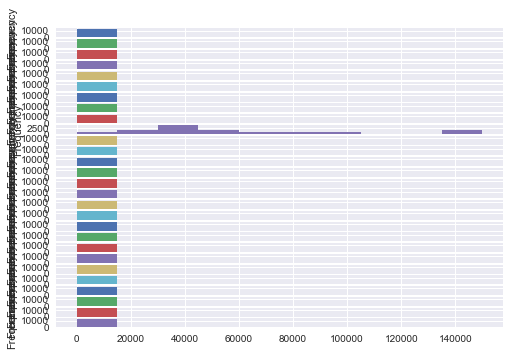

time: 1.54 s (started: 2022-10-29 06:12:38 -07:00)


In [22]:
plt.style.use('seaborn')

# Plotting as desired
df.plot.hist(subplots=True, legend=False)

In [23]:
# from io import StringIO
# import pandas as pd
# import matplotlib.pyplot as plt
# plt.style.use('seaborn')

# # Here I read your example data in
# df = pd.read_fwf(StringIO("""
#     X              Y          Z
# 0   1.000000    1.000000    1.014925    
# 1   1.000000    1.000000    1.000000
# """), header=1, index_col=0)

# # Plotting as desired
# df.plot.hist(subplots=True, legend=False)

time: 313 µs (started: 2022-10-29 06:12:39 -07:00)


In [24]:
#five types of coupons:
#bars
#takeaway food restaurants
#coffee houses
#cheap restaurants (average expense below $20 per person)
#expensive restaurants (average expense between $20 to $50 per person)

df.loc[:, 'coupon_venue_type'].value_counts()


Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon_venue_type, dtype: int64

time: 3.2 ms (started: 2022-10-29 06:12:39 -07:00)


In [25]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# dpi=100
# figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi' + str(dpi) + '_v' + filename_version + '.png'

# img = mpimg.imread(figure_filename)
# plt.imshow(img)
# plt.show()


# # reading png image
# im = img.imread('imR.png')

# lum = im[:, :, 0]

# # show image
# plt.imshow(lum)

time: 260 µs (started: 2022-10-29 06:12:39 -07:00)


In [26]:
# dpi=100
# figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi' + str(dpi) + '_v' + filename_version + '.png'

# img = mpimg.imread(figure_filename)

# if img.any() != None:
#     plt.figure(figsize=(30, 24))
#     plt.grid(False)
#     plt.axis('off')
#     plt.imshow(img)

time: 230 µs (started: 2022-10-29 06:12:39 -07:00)


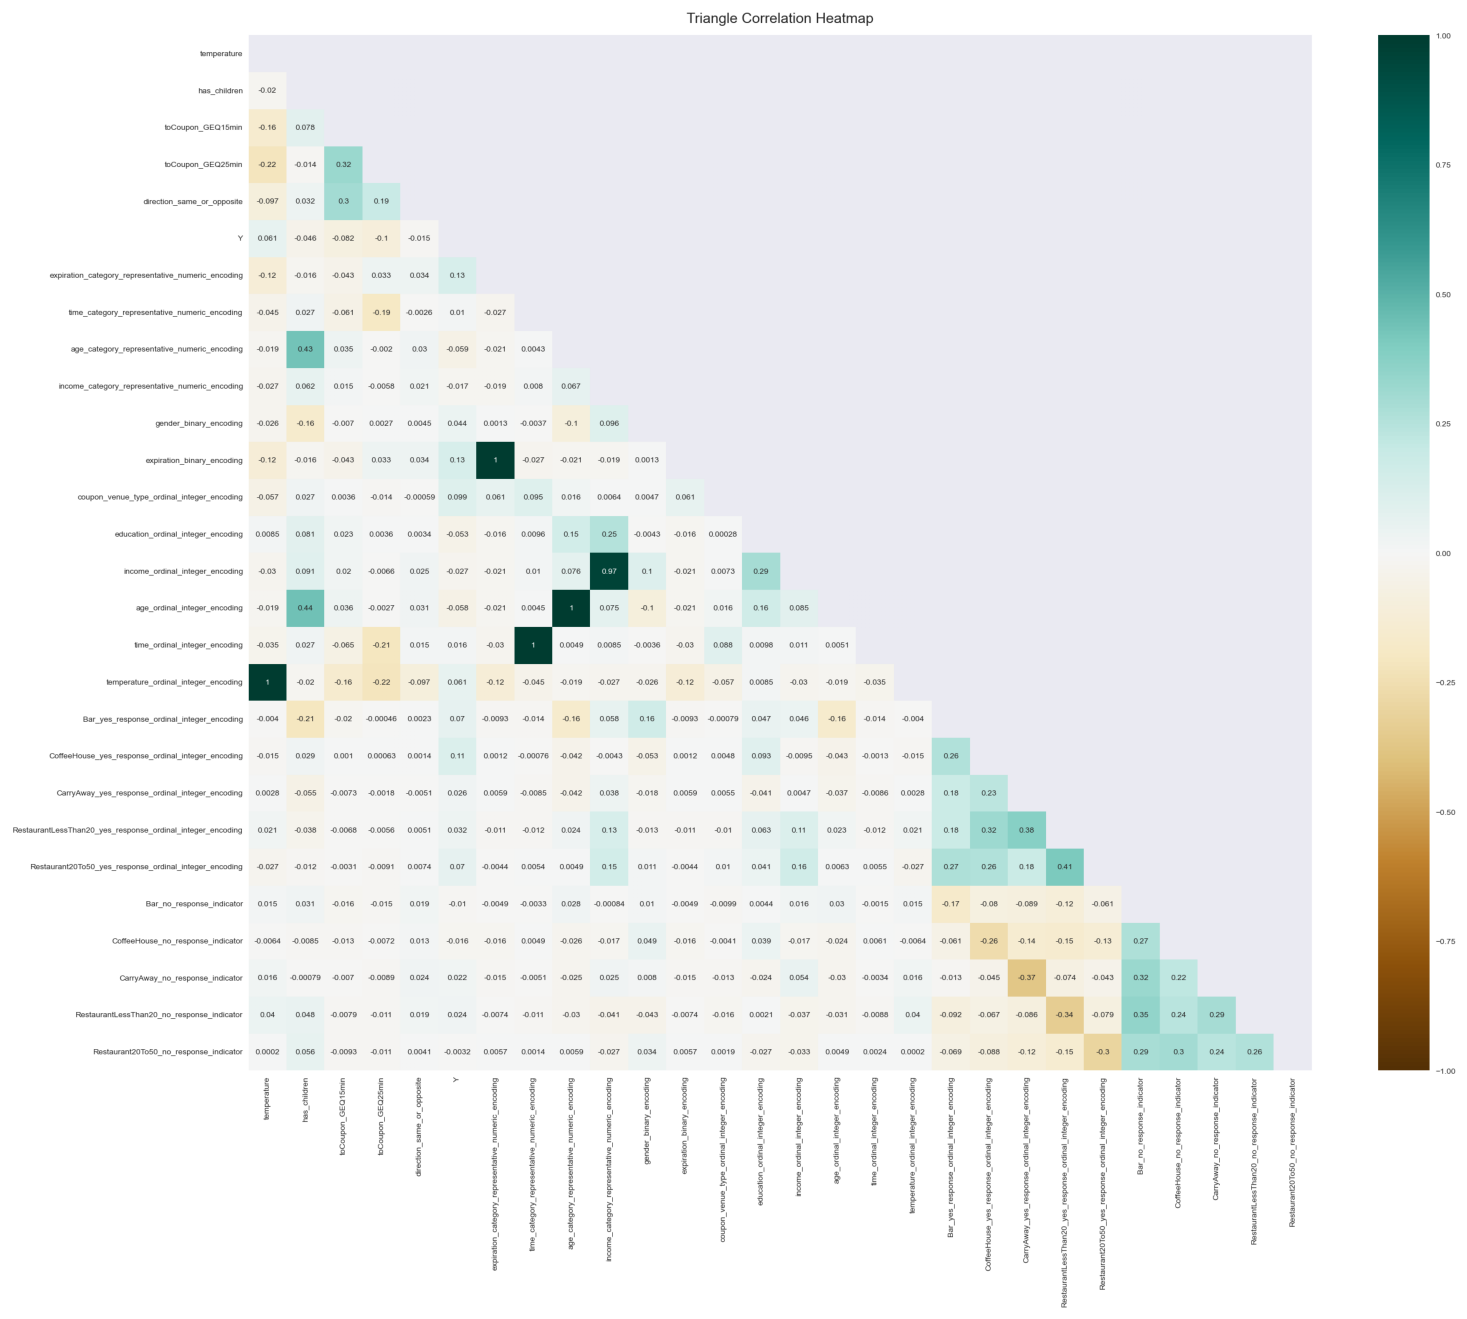

time: 703 ms (started: 2022-10-29 06:12:39 -07:00)


In [27]:
#correlation heatmap
dpi=100
figure_filename = '../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_dpi' + str(dpi) + '_v' + filename_version + '.png'

figure_filename_exists = os.path.isfile(figure_filename)

if figure_filename_exists == True:
    img = mpimg.imread(figure_filename)
    plt.figure(figsize=(30, 24))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

else:
    plt.figure(figsize=(30, 24))
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

    plt.savefig(figure_filename, bbox_inches='tight', dpi=dpi)

plt.show()

In [28]:
#^-----fix runtime here.

time: 165 µs (started: 2022-10-29 06:12:40 -07:00)


In [29]:
#.11 correlation between coupon acceptance and reported CoffeeHouse venue visit frequency

#.099 correlation between venue coupon type and coupon accpetance

#.13 correlation between coupon expiraton and coupon acceptance

#.07 correaltio between reported expensive restaurant visit frequency and coupon acceptance

#.07 correlation between coupon acceptance and reported bar visit frequency 

#.061 correlation between temperature and coupon acceptance

#-.1 correlation between coupon acceptance and driver travel time to venue is greater than 25 minute

#-.082 correlation between coupon acceptance and driver travel time to venue is greater than 15 minute

#-.046 correlation between having children and accpeting coupon

time: 366 µs (started: 2022-10-29 06:12:40 -07:00)


In [30]:
dir()

['GradientBoostingClassifier',
 'GridSearchCV',
 'In',
 'Out',
 'RandomForestClassifier',
 'StandardScaler',
 'StratifiedKFold',
 'StringIO',
 '_',
 '_14',
 '_15',
 '_18',
 '_19',
 '_20',
 '_22',
 '_24',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'accuracy_score',
 'color',
 'column_name',
 'column_name_list',
 'cross_val_score',
 'cross_validate',
 'datetime',
 'df',
 'df_expiration_category_representative_numeric_encoding_Y_coupon_accepted',
 'df_expiration_category_representative_numeric_encoding_Y_coupon_not_accepted',
 'dpi',
 'exit',
 'f1_score',
 'figure_filename',
 'figure_filena

time: 1.71 ms (started: 2022-10-29 06:12:40 -07:00)


<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

In [31]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

del df_categorical_features

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)

del df_numeric_features, 

p(df_indicator_numeric_features)


(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,55,1,0,0,1,24,14,23,43749.5,0,1,4,3,4,2,3,2,1,1,0,4,3,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

time: 63.1 ms (started: 2022-10-29 06:12:40 -07:00)


In [32]:
#standardize and scale feature data frame
standard_scaler = StandardScaler()
standardized_scaled_df_indicator_numeric_features_ndarray = standard_scaler.fit_transform(df_indicator_numeric_features)
df_indicator_numeric_features_standardized_scaled = pd.DataFrame(standardized_scaled_df_indicator_numeric_features_ndarray, columns=df_indicator_numeric_features.columns)

del df_indicator_numeric_features, standardized_scaled_df_indicator_numeric_features_ndarray

p(df_indicator_numeric_features_standardized_scaled)

(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,-0.585362,1.009347,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,2.305122,-0.584512,-0.576501,-0.434842,-0.482217,-0.678192,-0.365116,1.884878,0.888114,-0.888114,0.973698,-0.973698,1.944480,-0.502733,-0.437659,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,-0.774011,2.191433,-0.101761,-0.316214,-0.720572,-0.413491,-0.277185,-0.083584,1.383905,-0.118279,

time: 76.6 ms (started: 2022-10-29 06:12:40 -07:00)


In [33]:
#show near identical columns

time: 202 µs (started: 2022-10-29 06:12:40 -07:00)


In [34]:
#show duplicate columns as a data frame
df_duplicated = df_indicator_numeric_features_standardized_scaled.T.duplicated(keep=False)

p(df_indicator_numeric_features_standardized_scaled.loc[:, df_duplicated])

(12684, 16)


,destination_Work,time_7AM,expiration_1d,gender_Male,Bar_no response,CoffeeHouse_no response,CarryAway_no response,RestaurantLessThan20_no response,Restaurant20To50_no response,gender_binary_encoding,expiration_binary_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,-0.576501,-0.576501,0.888114,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,0.888114,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
1,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
2,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
3,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
4,-0.576501,-0.576501,0.888114,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,0.888114,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
12679,-0.576501,-0.576501,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12680,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12681,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12682,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12683,1.734604,1.734604,-1.125982,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,-1.125982,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988


time: 768 ms (started: 2022-10-29 06:12:40 -07:00)


In [35]:
p(df_target)

(12684, 1)


,Y
0,1
1,0
2,1
3,0
4,0
12679,1
12680,1
12681,0
12682,0
12683,0


time: 2.52 ms (started: 2022-10-29 06:12:41 -07:00)


In [36]:
#save preprocessed data frame
data_frame_version=filename_version
data_frame_collection_filename='data_frame_collection_train_test_v' + data_frame_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}
    
    #split the data into train and test
    data_frame_collection['X_train'], data_frame_collection['X_test'], data_frame_collection['Y_train'], data_frame_collection['Y_test'] = \
    train_test_split(df_indicator_numeric_features_standardized_scaled, df_target, test_size=.2, random_state=200, stratify=df_target)
    
    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename)

del df_indicator_numeric_features_standardized_scaled

p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
4946,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,-0.678192,2.738858,-0.530538,-1.125982,1.125982,-1.027012,1.027012,-0.514276,-0.502733,2.284884,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,1.291972,-0.456322,-0.101761,-0.316214,-0.720572,-0.413491,3.607696,-0.083584,-0.722593,-0.1182

time: 67.7 ms (started: 2022-10-29 06:12:41 -07:00)


In [37]:
#fair to use stratified splits between train and test????

    #creates an artificially favorable ratio when the sample is split to represent the test set (i.e. like another sample population)
    
    #our dataset is a sample population and our marketing campaign will target a sample population.
    
    
    #the reality is our sample population is like taking a random sample, and targeted ads are shown to the subgroup of another sample population.
    #we can't control target variable data representation going from our survey to the in field targeted ads, so we shouldn't control it here???
    
    #OR
    
    #we are controling the target variable representation to fix a variable we don't want to worry about down the line. Down the line, we will have 
    #more data on customer behavior and considering the size of the hold out set, we want it to be representative of a larger dataset (i.e. our train data
    # which we believe is representative of the target population)
    

time: 482 µs (started: 2022-10-29 06:12:41 -07:00)


In [38]:
print(data_frame_collection['X_train'].shape, data_frame_collection['X_test'].shape, data_frame_collection['Y_train'].shape, data_frame_collection['Y_test'].shape)

(10147, 140) (2537, 140) (10147, 1) (2537, 1)
time: 554 µs (started: 2022-10-29 06:12:41 -07:00)


In [39]:
#this filtered survey as a dataset is our best approximation of the population????

#how do we know what the population is??? the population is those are targeting to coupon recommendation??? we are defining the population then???

#we could go the route of create ML based on the general population???? i mean there is already biased based on who would take a survey???
#i am assuming there is a bias for lower income individuals in surveys because they take time and don't pay well

#what is the demographic distribution of america by income??? <--- not going to be our target audience because coupon users and survey takers
#are going to be lower income than the general population of america.

#there is an inherit bias because coupon users and survey takers are different???


time: 403 µs (started: 2022-10-29 06:12:41 -07:00)


In [40]:
#we don't know what are target audience of coupon acceptor is, this what we are trying to figure out!!

#class label stratification seems to make sense here then???



time: 228 µs (started: 2022-10-29 06:12:41 -07:00)


In [41]:
dir()

['GradientBoostingClassifier',
 'GridSearchCV',
 'In',
 'Out',
 'RandomForestClassifier',
 'StandardScaler',
 'StratifiedKFold',
 'StringIO',
 '_',
 '_14',
 '_15',
 '_18',
 '_19',
 '_20',
 '_22',
 '_24',
 '_30',
 '_31',
 '_32',
 '_34',
 '_35',
 '_36',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'accuracy_score',
 'color',
 'column_name',
 'column_name_list',
 'column_name_list_not_numeric',
 'column_name_list_numeric',
 'cross_val_score',
 'cross_validate',
 'data_frame_collection',
 'data_f

time: 2.51 ms (started: 2022-10-29 06:12:41 -07:00)


## Get Stratified 5-Fold Cross Validation X_train, X_test, Y_train, Y_test Collection

In [42]:
#stratified 5-fold cross validation train-test data row selection

#Stratified 5-Fold object
StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#get stratfied 5-fold data frame splits
stratified_fold_number_X_train_X_test_Y_train_Y_test_collection = {}


for index, (train_index, test_index) in enumerate(StratifiedKFold_5_splits.split(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])):
    print('fold ' + str(index) + " TRAIN:", train_index, "TEST:", test_index)
    stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)] = \
    {'X_train' : data_frame_collection['X_train'].iloc[train_index, :], \
     'X_test' : data_frame_collection['X_train'].iloc[test_index, :], \
     'Y_train' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[train_index], \
     'Y_test' : data_frame_collection['Y_train'].loc[:, 'Y'].iloc[test_index]}

#use .loc for selection by index label, .iloc for selection by index location

print()
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'])

fold 0 TRAIN: [ 2011  2013  2014 ... 10144 10145 10146] TEST: [   0    1    2 ... 2049 2050 2051]
fold 1 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [2011 2013 2014 ... 4079 4080 4081]
fold 2 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [4009 4012 4014 ... 6132 6134 6135]
fold 3 TRAIN: [    0     1     2 ... 10144 10145 10146] TEST: [6036 6038 6039 ... 8139 8140 8144]
fold 4 TRAIN: [   0    1    2 ... 8139 8140 8144] TEST: [ 8098  8099  8102 ... 10144 10145 10146]

(8117, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
2469,-0.585362,-0.990740,1.734604,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,-0.584512,1.734604,2.299684,-0.482217,-0.678192,-0.365116,-0.530538,0.888114,-0.888114,0.973698,-0.973698,1.944480,-0.502733,-0.437659,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,-0.774011,2.191433,-0.101761,-0.316214,-0.720572,-0.413491,-0.277185,-0.083584,1.383905,-0.1182

time: 87.9 ms (started: 2022-10-29 06:12:41 -07:00)


In [43]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_train'])

(8117,)


2469     1
2037     1
4070     1
2845     1
10213    1
6626     1
477      1
2716     1
615      1
2246     1
Name: Y, dtype: int64

time: 2.53 ms (started: 2022-10-29 06:12:41 -07:00)


In [44]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'])

(2030, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
4946,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,-0.678192,2.738858,-0.530538,-1.125982,1.125982,-1.027012,1.027012,-0.514276,-0.502733,2.284884,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,1.291972,-0.456322,-0.101761,-0.316214,-0.720572,-0.413491,3.607696,-0.083584,-0.722593,-0.1182

time: 58.8 ms (started: 2022-10-29 06:12:41 -07:00)


In [45]:
p(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_test'])

(2030,)


4946     1
7280     0
6560     0
7889     0
644      1
12475    0
2466     0
5494     0
12175    0
9769     0
Name: Y, dtype: int64

time: 2.73 ms (started: 2022-10-29 06:12:41 -07:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Initialize Filename Collection Variables

In [46]:
classifier_name_list = ['random_forest_classifier', 'gradient_boosting_classifier']

grid_search_models_filename_collection={}
model_filename_collection = {}
model_cross_validation_results_collection = {}
learning_curve_results_collection = {}


for classifier_name in classifier_name_list:
    grid_search_models_filename_collection[classifier_name]='stratified_5_fold_grid_search_cross_validation_' + classifier_name + '_v' + filename_version + '.pkl'

    model_filename_collection[classifier_name]='best_stratified_5_fold_grid_search_cross_validation_'+ classifier_name + '_v' + filename_version + '.pkl'

    model_cross_validation_results_collection[classifier_name]='best_' + classifier_name + '_stratified_5_fold_cross_validation_results_v' + filename_version + '.pkl'

    learning_curve_results_collection[classifier_name]='learning_curve_results_best_' + classifier_name + '_v' + filename_version + '.pkl'



time: 796 µs (started: 2022-10-29 06:12:41 -07:00)


In [47]:
#initialize variables
model_version=filename_version
model_filename='best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'
grid_search_models_filename='stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'
model_cross_validation_results = 'best_random_forest_classifier_stratified_5_fold_cross_validation_results_v' + model_version + '.pkl'

time: 419 µs (started: 2022-10-29 06:12:41 -07:00)


## Random Forest Classifier Stratified 5-Fold Cross Validation Grid Search by Accuracy

In [48]:
model_filename='best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'
grid_search_models_filename='stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'

#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['random_forest_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = models_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [3, 5, 10, 20, 25, None], #ba 3, past 25 is a lot (and can be left to whatever large max depth then); previously [5, 10, 20, 25, 30, 35, 40]
        'min_samples_split': [1, 10, 50, 100], #ba 1, 10, 50, 100; previously [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        'min_samples_leaf':[1],
        'n_estimators': [200], #more is better, otherwise these are just random variation
        'warm_start':[False]
    }
    #min_samples_leaf can be used as an alternative to 'min_samples_split'
    
    #RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       #n_estimators=200, random_state=200)

    # Create a based model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    #Stratified 5-Fold oject
    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = GridSearchCV(estimator=random_forest_classifier, 
                                                                                           param_grid=param_grid, 
                                                                                           cv=StratifiedKFold_5_splits,
                                                                                           n_jobs=-1, 
                                                                                           verbose=0,
                                                                                           scoring=None)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier.fit(data_frame_collection['X_train'], data_frame_collection['Y_train'].loc[:, 'Y'])

    #save it
    stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model2(stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                         filename=grid_search_models_filename,
                                                                                                         add_compressed_file=False)
    
    #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

stratified_5_fold_grid_search_cross_validation_random_forest_classifier

This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=200), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'criterion': ['gini'],
                         'max_depth': [3, 5, 10, 20, 25, None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 10, 50, 100],
                         'n_estimators': [200], 'warm_start': [False]})

time: 79 ms (started: 2022-10-29 06:12:41 -07:00)


In [49]:
#scoring? multimetric??

time: 194 µs (started: 2022-10-29 06:12:41 -07:00)


## Get Best Random Forest Classifier by Accuracy

In [50]:
#get best random forest classifier
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['random_forest_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation_random_forest_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model2(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename,
                                                                                                              add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier


This file already exists


RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                       random_state=200)

time: 90.3 ms (started: 2022-10-29 06:12:41 -07:00)


In [51]:
#Regarding how to evaluate the performance of a classifier, especially when the data is imbalanced between classes, 
#you could consider precision and recall as your metrics of choice. I think it's a better measure of how 'good' a 
#classifier is than straight accuracy or auc for roc curves (without knowing more about your context/goals).



#Precision = TruePositives / (TruePositives + FalsePositives)
#Recall = TruePositives / (TruePositives + FalseNegatives)


time: 307 µs (started: 2022-10-29 06:12:41 -07:00)


In [52]:
#this suggests we have a better prediction of coupon acceptance among those who actually accept the coupon
#compared to our prediction of coupon acceptance among those we predict are going to accept the coupon.

#what does this mean? does it matter???

#how does it effect the business problem??

#precision is possibly those who we would want to market to. Of this group, we have a 0.83 acceptance rate.

time: 291 µs (started: 2022-10-29 06:12:41 -07:00)


In [53]:
#recall is those that would actual accept the coupon, so it's our hindsight 20 20.

time: 189 µs (started: 2022-10-29 06:12:41 -07:00)


In [54]:
#should be using cross validation score precision and recall.

#there a function for this???



time: 198 µs (started: 2022-10-29 06:12:41 -07:00)


In [55]:
#get proper parameters??

time: 157 µs (started: 2022-10-29 06:12:41 -07:00)


## Get Stratified 5-Fold Cross Validation Best Random Forest Classifier Results

In [56]:
data_collection_readback = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_results_collection['random_forest_classifier'])
if data_collection_readback != None:
    best_random_forest_classifier_stratified_5_fold_cross_validation_results = data_collection_readback
else:
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}

    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                    max_depth=25, 
                                                    min_samples_split=4, 
                                                    n_estimators=200,
                                                    min_samples_leaf=1,
                                                    max_features='auto',
                                                    criterion='gini',
                                                    warm_start='False',
                                                    random_state=200)

    best_random_forest_classifier_stratified_5_fold_cross_validation_results = cross_validate(estimator=random_forest_classifier,
                                                                                              X=data_frame_collection['X_train'],
                                                                                              y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                              cv=StratifiedKFold_5_splits,
                                                                                              scoring=scoring)
    #save it
    best_random_forest_classifier_stratified_5_fold_cross_validation_results = icr.save_and_return_collection(best_random_forest_classifier_stratified_5_fold_cross_validation_results, 
                                                                                                              filename=model_cross_validation_results)

model_stratified_5_fold_cross_validation_results_collection = {}

model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier'] = best_random_forest_classifier_stratified_5_fold_cross_validation_results
model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']



This file already exists


{'fit_time': array([2.03802085, 2.00992799, 2.0113821 , 2.01069117, 1.99911499]),
 'score_time': array([0.08459306, 0.07695794, 0.07898283, 0.07790804, 0.07438207]),
 'test_accuracy': array([0.75320197, 0.75615764, 0.75603746, 0.76244455, 0.77378019]),
 'test_precision': array([0.762249  , 0.76766856, 0.75883739, 0.7712207 , 0.77279874]),
 'test_recall': array([0.82235702, 0.81889081, 0.83708839, 0.82740676, 0.85255854]),
 'test_f1_score': array([0.79116298, 0.79245283, 0.7960445 , 0.79832636, 0.81072165])}

time: 4.21 ms (started: 2022-10-29 06:12:41 -07:00)


In [57]:
print("model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_precision'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_precision'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_recall'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_recall'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_f1_score'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_f1_score'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_accuracy'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_accuracy'].mean()))


del best_random_forest_classifier_stratified_5_fold_cross_validation_results

model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_precision'].mean(): 0.7665548774969452
model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_recall'].mean(): 0.8316603059459086
model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_f1_score'].mean(): 0.7977416646929423
model_stratified_5_fold_cross_validation_results_collection['best_random_forest_classifier']['test_accuracy'].mean(): 0.7603243608076973
time: 1.24 ms (started: 2022-10-29 06:12:41 -07:00)


In [58]:
#^---- recall possibly high because of class imbalance toward in-vehicle coupon recommendation??????

#this an ML problem??

#this a survey problem methods problem?????? or just a normal issue dealt with???

#bootstrapping the dataset for a class balance better??? 



time: 258 µs (started: 2022-10-29 06:12:41 -07:00)


In [59]:
#is it possible recall is just easier than precision in general????

#are there cases where precision is higher than recall????



time: 233 µs (started: 2022-10-29 06:12:41 -07:00)


In [60]:
#should have built random forest to optimize for f1 score??? what about the more fundamental precision or recall?? 
#acccuracy seems more all encompassing on just getting the correct prediction instead of focusing on rates related to coupon acceptance???


time: 260 µs (started: 2022-10-29 06:12:41 -07:00)


In [61]:
#want 5-fold cross validation prediction structure for random forest from N estimators

time: 197 µs (started: 2022-10-29 06:12:41 -07:00)


In [62]:
#want to train 5 random forest classifier using each of the train folds 0, 1, 2, 3, 4

#next want to use each random forest classifier to get predictions from each estimator per test fold (i.e. folds 0, 1, 2, 3, 4)



time: 399 µs (started: 2022-10-29 06:12:41 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Collection

In [63]:
cross_validation_model_collection = 'stratified_5_fold_cross_validation_random_forest_classifier_collection_v' + model_version + '.pkl'

models_readback = icr.return_saved_model_if_it_exists(filename=cross_validation_model_collection)
if models_readback != None:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = models_readback
else:
    stratified_5_fold_cross_validation_random_forest_classifier_collection = {}
    for index in range(5):

        #create random forest classifier
        random_forest_classifier=RandomForestClassifier(bootstrap=False, 
                                                        max_depth=None, 
                                                        min_samples_split=10, 
                                                        n_estimators=200,
                                                        min_samples_leaf=1,
                                                        max_features='auto',
                                                        criterion='gini',
                                                        warm_start='False',
                                                        random_state=200)
        
        #RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                       #random_state=200)

        #train random forest classifier and save random forest classifer per fold
        random_forest_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_train'],
                                     y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['Y_train'])

        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)] = random_forest_classifier


    #save stratified 5-fold cross validation random forest classifier collection
    stratified_5_fold_cross_validation_random_forest_classifier_collection = icr.save_and_return_model2(stratified_5_fold_cross_validation_random_forest_classifier_collection, 
                                                                                                        filename=cross_validation_model_collection,
                                                                                                        add_compressed_file=False)
stratified_5_fold_cross_validation_random_forest_classifier_collection


This file already exists


{'fold 0': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 1': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 2': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 3': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False'),
 'fold 4': RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                        random_state=200, warm_start='False')}

time: 334 ms (started: 2022-10-29 06:12:41 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Collection

In [64]:
cross_validation_model_prediction_collection = 'stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection_v' + model_version + '.pkl'

prediction_data_frame_collection = icr.return_processed_collection_if_it_exists(filename=cross_validation_model_prediction_collection)
if prediction_data_frame_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection = prediction_data_frame_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    
    
    #data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename, index=False, parse_dates=False)


    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection, 
                                                                                                                       filename=cross_validation_model_prediction_collection)
stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection['fold 0']


This file already exists


array([0, 0, 1, ..., 0, 0, 0])

time: 3.66 ms (started: 2022-10-29 06:12:42 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Prediction Probability Collection

In [65]:
cross_validation_model_prediction_probability_collection = 'stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection_v' + model_version + '.pkl'

prediction_probability_data_frame_collection = icr.return_processed_collection_if_it_exists(filename=cross_validation_model_prediction_collection)
if prediction_data_frame_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = prediction_probability_data_frame_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = {}
    for index in range(5):
        #get predictions for test per fold
        stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold ' + str(index)] = \
        stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(index)]\
        .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(index)]['X_test'])
    
    
    #data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename, index=False, parse_dates=False)


    #save stratified 5-fold cross validation random forest classifier prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection = icr.save_and_return_collection(data_frame_collection=stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection, 
                                                                                                                       filename=cross_validation_model_prediction_probability_collection)
stratified_5_fold_cross_validation_random_forest_classifier_prediction_probability_collection['fold 0']


This file already exists


array([0, 0, 1, ..., 0, 0, 0])

time: 3.7 ms (started: 2022-10-29 06:12:42 -07:00)


In [66]:
import warnings
warnings.filterwarnings('ignore')

time: 375 µs (started: 2022-10-29 06:12:42 -07:00)


## Get Stratified 5-Fold Cross Validation Random Forest Classifier Estimator Prediction Probability Collection

In [67]:
#prediction probability collection
cross_validation_model_estimator_prediction_probability_collection = 'stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection_v' + model_version + '.pkl'

list_array_collection = icr.return_processed_collection_if_it_exists(filename=cross_validation_model_estimator_prediction_probability_collection)
if list_array_collection != None:
    stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection = list_array_collection
else:
    stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection = {}
    for fold_index in range(5):

        number_of_rows_in_fold = stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_index)]['X_test'].shape[0]
        class1_probability_index = [class1_index for class1_index in range(2*number_of_rows_in_fold) if class1_index % 2 != 0]
        
        stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection['fold ' + str(fold_index)] = \
        pd.DataFrame([stratified_5_fold_cross_validation_random_forest_classifier_collection['fold ' + str(fold_index)].estimators_[estimator_index]\
         .predict_proba(stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_index)]['X_test']).flatten()[class1_probability_index] \
         for estimator_index in range(200)]).T


    #save stratified 5-fold cross validation random forest classifier estimator prediction collection
    stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection = icr.save_and_return_collection(stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection, 
                                                                                                                                             filename=cross_validation_model_estimator_prediction_probability_collection)

p(stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection['fold 0'])


This file already exists
(2030, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.000000,0.142857,0.500000,0.000000,1.000000,1.000000,0.600000,0.500000,0.000000,0.142857,0.625000,0.833333,0.000000,0.600000,0.000000,1.000000,0.666667,0.222222,0.444444,0.125000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.375000,0.000000,0.833333,0.000000,0.200000,0.666667,0.111111,0.250000,0.000000,0.000000,1.000000,0.714286,1.000000,0.222222,0.000000,0.750000,1.000000,0.125000,0.555556,0.333333,0.222222,0.000000,0.750000,0.222222,1.000000,0.000000,1.000000,0.000000,0.500,0.000000,0.333333,0.111111,0.111111,0.000000,0.375000,1.000000,0.000000,0.250000,0.000000,0.000000,0.111111,0.222222,0.500,0.800000,0.222222,0.000000,0.571429,0.285714,0.714286,0.500000,0.750000,0.000000,0.428571,1.000000,0.125000,0.375000,0.000000,1.000000,0.444444,0.400000,0.000000,0.000000,0.250000,0.000000,0.500000,0.666667,0.571429,0.250000,0.333333,1.000000,0.250000,0.333333,0.333333,0.750000,0.500,1.000000,1.000000,0.000000,0.000000,0.285714,0.250000,1.000000,1.000000,0.200000,0.555556,0.000000,0.444444,0.000000,1.000000,0.285714,0.500000,1.000000,0.000,0.625000,0.571429,0.666667,0.000000,0.000000,0.000000,0.500000,0.250000,0.444444,0.500000,0.666667,1.000000,0.000000,0.000000,1.000000,0.250000,0.444444,1.000000,0.000000,0.250000,0.666667,1.000000,0.000000,0.875000,0.50,0.142857,0.000000,0.500000,0.800000,0.285714,0.250000,0.500000,0.250,0.375000,0.333333,0.833333,0.000000,0.800000,0.250000,0.166667,0.750000,0.285714,0.285714,0.444444,0.142857,0.111111,0.444444,0.428571,0.333333,0.333333,0.000000,0.000000,0.285714,1.000000,0.000000,0.000000,0.888889,0.888889,0.000000,0.555556,0.000000,0.000000,0.000000,0.000000,0.222222,0.500000,0.571429,0.142857,1.000000,0.000000,0.000000,0.500000,0.666667,0.166667,0.600000,0.000000,0.571429,1.000000,0.000000,1.000000
1,0.888889,0.000000,0.714286,0.000000,0.222222,0.000000,0.333333,0.666667,0.250000,0.000000,0.142857,0.444444,0.222222,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000,0.000000,0.166667,0.222222,0.000000,0.142857,0.000000,0.444444,0.250000,0.400000,0.142857,0.333333,0.800000,0.000000,0.166667,0.750000,1.000000,0.555556,0.714286,0.285714,0.111111,0.555556,0.000000,0.625000,0.000000,0.250000,0.142857,0.000000,1.000000,0.125000,0.000000,0.142857,0.000000,0.166667,0.125000,0.166667,0.222222,0.000,0.250000,0.000000,0.000000,0.000000,0.333333,0.714286,0.750000,0.333333,0.250000,0.333333,0.571429,0.000000,0.111111,0.000,0.000000,0.000000,0.000000,0.333333,0.222222,0.400000,0.750000,0.500000,0.666667,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.714286,0.111111,0.500000,0.166667,0.000000,0.000000,0.125000,0.222222,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000,0.000000,0.000000,0.000000,0.500000,0.000000,0.166667,0.166667,0.857143,0.333333,0.375000,0.250000,0.571429,0.000000,0.333333,0.250000,0.125000,0.000000,0.000,0.428571,0.000000,0.250000,1.000000,0.428571,0.000000,0.714286,0.875000,0.000000,0.800000,0.333333,0.000000,0.111111,0.000000,0.250000,0.250000,0.285714,0.166667,0.000000,0.000000,0.400000,0.000000,0.111111,0.000000,0.00,0.000000,0.500000,0.333333,0.000000,0.000000,0.000000,0.000000,0.375,0.444444,0.222222,0.285714,0.285714,0.142857,0.666667,0.333333,0.000000,1.000000,0.000000,0.250000,0.800000,0.200000,0.250000,0.000000,0.000000,0.250000,0.571429,0.57

time: 102 ms (started: 2022-10-29 06:12:42 -07:00)


## Convert to Estimator Predicition Probability Data Frame from Estimator Prediction Probability Data Frame Collection

In [68]:
#convert estimator prediction probability collection folds 0 thru 4 to a single data frame
data_frame_list = [stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection['fold ' + str(fold_index)] for fold_index in range(5)]
del stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_collection
df_estimator_prediction_probability = pd.concat(data_frame_list)
df_estimator_prediction_probability = df_estimator_prediction_probability.reset_index(drop=True)


#get column name dictionary
column_name_list_number = [number for number in range(200)]
column_name_list_estimator_number_prediction_probability = ['estimator' + str(number) + '_prediction_probability' for number in range(200)]
column_name_dict_estimator_number_prediction_probability = dict(zip(column_name_list_number, column_name_list_estimator_number_prediction_probability))

#rename columns
df_estimator_prediction_probability = df_estimator_prediction_probability.rename(columns=column_name_dict_estimator_number_prediction_probability)


p(df_estimator_prediction_probability)

(10147, 200)


,estimator0_prediction_probability,estimator1_prediction_probability,estimator2_prediction_probability,estimator3_prediction_probability,estimator4_prediction_probability,estimator5_prediction_probability,estimator6_prediction_probability,estimator7_prediction_probability,estimator8_prediction_probability,estimator9_prediction_probability,estimator10_prediction_probability,estimator11_prediction_probability,estimator12_prediction_probability,estimator13_prediction_probability,estimator14_prediction_probability,estimator15_prediction_probability,estimator16_prediction_probability,estimator17_prediction_probability,estimator18_prediction_probability,estimator19_prediction_probability,estimator20_prediction_probability,estimator21_prediction_probability,estimator22_prediction_probability,estimator23_prediction_probability,estimator24_prediction_probability,estimator25_prediction_probability,estimator26_prediction_probability,estimator27_prediction_probability,estimator28_prediction_probability,estimator29_prediction_probability,estimator30_prediction_probability,estimator31_prediction_probability,estimator32_prediction_probability,estimator33_prediction_probability,estimator34_prediction_probability,estimator35_prediction_probability,estimator36_prediction_probability,estimator37_prediction_probability,estimator38_prediction_probability,estimator39_prediction_probability,estimator40_prediction_probability,estimator41_prediction_probability,estimator42_prediction_probability,estimator43_prediction_probability,estimator44_prediction_probability,estimator45_prediction_probability,estimator46_prediction_probability,estimator47_prediction_probability,estimator48_prediction_probability,estimator49_prediction_probability,estimator50_prediction_probability,estimator51_prediction_probability,estimator52_prediction_probability,estimator53_prediction_probability,estimator54_prediction_probability,estimator55_prediction_probability,estimator56_prediction_probability,estimator57_prediction_probability,estimator58_prediction_probability,estimator59_prediction_probability,estimator60_prediction_probability,estimator61_prediction_probability,estimator62_prediction_probability,estimator63_prediction_probability,estimator64_prediction_probability,estimator65_prediction_probability,estimator66_prediction_probability,estimator67_prediction_probability,estimator68_prediction_probability,estimator69_prediction_probability,estimator70_prediction_probability,estimator71_prediction_probability,estimator72_prediction_probability,estimator73_prediction_probability,estimator74_prediction_probability,estimator75_prediction_probability,estimator76_prediction_probability,estimator77_prediction_probability,estimator78_prediction_probability,estimator79_prediction_probability,estimator80_prediction_probability,estimator81_prediction_probability,estimator82_prediction_probability,estimator83_prediction_probability,estimator84_prediction_probability,estimator85_prediction_probability,estimator86_prediction_probability,estimator87_prediction_probability,estimator88_prediction_probability,estimator89_prediction_probability,estimator90_prediction_probability,estimator91_prediction_probability,estimator92_prediction_probability,estimator93_prediction_probability,estimator94_prediction_probability,estimator95_prediction_probability,estimator96_prediction_probability,estimator97_prediction_probability,estimator98_prediction_probability,estimator99_prediction_probability,estimator100_prediction_probability,estimator101_prediction_probability,estimator102_prediction_probability,estimator103_prediction_probability,estimator104_prediction_probability,estimator105_prediction_probability,estimator106_prediction_probability,estimator107_prediction_probability,estimator108_prediction_probability,estimator109_prediction_probability,estimator110_prediction_probability,estimator111_prediction_probability,estimator112_prediction_probability,estimator113_prediction_probability,estim

time: 114 ms (started: 2022-10-29 06:12:42 -07:00)


## Get 10,000 Estimator Prediction Probability n=5 Bootstrap Means

In [69]:
#get bootstrap n=5 samples, 10,000 replicas
np.random.seed(seed=200)
estimator_prediction_probability_n_5_bootstrap_mean = pd.DataFrame([df_estimator_prediction_probability.sample(n=5, replace=True, weights=None, random_state=None, axis=1, ignore_index=False).mean(axis=1) for i in range(10000)]).T


#get column name dictionary
column_name_list_bootstrap_mean_number = [bootstrap_mean_number for bootstrap_mean_number in range(10000)]
column_name_list_estimator_prediction_probability_n_5_bootstrap_mean_number = ['estimator_prediction_probability_n_5_boostrap_mean' + str(sample_number) for sample_number in range(10000)]
column_name_dict_estimator_prediction_probability_n_5_bootstrap_mean_number = dict(zip(column_name_list_bootstrap_mean_number, column_name_list_estimator_prediction_probability_n_5_bootstrap_mean_number))

#rename columns
estimator_prediction_probability_n_5_bootstrap_mean = estimator_prediction_probability_n_5_bootstrap_mean.rename(columns=column_name_dict_estimator_prediction_probability_n_5_bootstrap_mean_number)

p(estimator_prediction_probability_n_5_bootstrap_mean)
#n=????

#number of bootstrap means???



(10147, 10000)


estimator_prediction_probability_n_5_boostrap_mean0  \
0                                                 0.327778   
1                                                 0.238889   
2                                                 0.900000   
3                                                 0.711667   
4                                                 0.883333   
10142                                             0.825000   
10143                                             0.711111   
10144                                             0.875556   
10145                                             1.000000   
10146                                             0.517778   

       estimator_prediction_probability_n_5_boostrap_mean1  \
0                                                 0.235714   
1                                                 0.240476   
2                                                 0.685000   
3                                                 0.571429   
4                                                 0.662857   
10142                                             0.791111   
10143                                             0.921429   
10144                                             0.455556   
10145                                             0.933333   
10146                                             0.505556   

       estimator_prediction_probability_n_5_boostrap_mean2  \
0                                                 0.550000   
1                                                 0.050000   
2                                                 0.604444   
3                                                 0.753333   
4                                                 0.853333   
10142                                             0.800000   
10143                                             0.836111   
10144                                             0.520000   
10145                                             0.933333   
10146                                             0.725000   

       estimator_prediction_probability_n_5_boostrap_mean3  \
0                                                 0.495238   
1                                                 0.273810   
2                                                 0.554365   
3                                                 0.606667   
4                                                 0.753333   
10142                                             0.826667   
10143                                             0.920000   
10144                                             0.966667   
10145                                             0.950000   
10146                                             0.155000   

       estimator_prediction_probability_n_5_boostrap_mean4  \
0                                                 0.413889   
1                                                 0.406429   
2                                                 0.602778   
3                                                 0.825397   
4                                                 0.854762   
10142                                             0.831746   
10143                                             0.861111   
10144                                             0.711111   
10145                                             0.750000   
10146                                             0.800000   

       estimator_prediction_probability_n_5_boostrap_mean5  \
0                                                 0.340476   
1                                                 0.244444   
2                                                 0.600000   
3                                                 0.531667   
4                                                 0.705556   
10142                                             0.786111   
10143                                             0.975000   
10144                                             1.000000   
10145                             

time: 6.14 s (started: 2022-10-29 06:12:42 -07:00)


## Get Estimator Prediction Probability n=5 Bootstrap Mean Quantiles

In [70]:
data_frame_filename = 'stratified_5_fold_cross_validation_random_forest_classifier_estimator_prediction_probability_bootstrap_mean_quantile_data_frame_v' + model_version + '.pkl'

data_frame_readback = icr.return_processed_data_file_if_it_exists(filename=data_frame_filename, parse_dates=False)
if data_frame_readback.empty == False:
    df_estimator_prediction_probability_bootstrap_mean_quantile = data_frame_readback
else:
    quantile_list = [estimator_prediction_probability_n_5_bootstrap_mean.quantile(q=index/200, axis=1) for index in range(201)]

    df_estimator_prediction_probability_bootstrap_mean_quantile = pd.DataFrame(quantile_list).T
    
    #save it
    df_estimator_prediction_probability_bootstrap_mean_quantile = icr.save_and_return_data_frame(df=df_estimator_prediction_probability_bootstrap_mean_quantile, filename=data_frame_filename, index=False, parse_dates=False, index_label=None)

p(df_estimator_prediction_probability_bootstrap_mean_quantile)


This file already exists
(10147, 201)


,0.0,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.055,0.06,0.065,0.07,0.075,0.08,0.085,0.09,0.095,0.1,0.105,0.11,0.115,0.12,0.125,0.13,0.135,0.14,0.145,0.15,0.155,0.16,0.165,0.17,0.175,0.18,0.185,0.19,0.195,0.2,0.205,0.21,0.215,0.22,0.225,0.23,0.235,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.275,0.28,0.285,0.29,0.295,0.3,0.305,0.31,0.315,0.32,0.325,0.33,0.335,0.34,0.345,0.35,0.355,0.36,0.365,0.37,0.375,0.38,0.385,0.39,0.395,0.4,0.405,0.41,0.415,0.42,0.425,0.43,0.435,0.44,0.445,0.45,0.455,0.46,0.465,0.47,0.475,0.48,0.485,0.49,0.495,0.5,0.505,0.51,0.515,0.52,0.525,0.53,0.535,0.54,0.545,0.55,0.555,0.56,0.565,0.57,0.575,0.58,0.585,0.59,0.595,0.6,0.605,0.61,0.615,0.62,0.625,0.63,0.635,0.64,0.645,0.65,0.655,0.66,0.665,0.67,0.675,0.68,0.685,0.69,0.695,0.7,0.705,0.71,0.715,0.72,0.725,0.73,0.735,0.74,0.745,0.75,0.755,0.76,0.765,0.77,0.775,0.78,0.785,0.79,0.795,0.8,0.805,0.81,0.815,0.82,0.825,0.83,0.835,0.84,0.845,0.85,0.855,0.86,0.865,0.87,0.875,0.88,0.885,0.89,0.895,0.9,0.905,0.91,0.915,0.92,0.925,0.93,0.935,0.94,0.945,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995,1.0
0,0.000000,0.044444,0.066667,0.082143,0.095238,0.102206,0.116667,0.123810,0.133333,0.139683,0.146032,0.150000,0.155556,0.160714,0.166667,0.171429,0.175000,0.178889,0.183333,0.187120,0.190476,0.195238,0.200000,0.200000,0.203175,0.208333,0.211111,0.214423,0.217460,0.222222,0.224349,0.227778,0.230159,0.233333,0.237460,0.240000,0.244351,0.245238,0.247619,0.250000,0.253095,0.256667,0.257143,0.261111,0.264286,0.266667,0.268181,0.271429,0.274171,0.275000,0.278512,0.280952,0.283333,0.285714,0.288889,0.288889,0.291667,0.294444,0.296667,0.300000,0.300000,0.301111,0.303571,0.306349,0.308333,0.311111,0.311905,0.314286,0.316667,0.317778,0.320000,0.322222,0.323810,0.325397,0.328571,0.330952,0.333333,0.333333,0.336508,0.338889,0.341667,0.343046,0.345238,0.348155,0.350000,0.350000,0.352778,0.355556,0.357143,0.359921,0.361798,0.364105,0.366667,0.366667,0.369444,0.371429,0.373333,0.375678,0.377778,0.379365,0.381389,0.383333,0.385000,0.387302,0.388889,0.390476,0.392857,0.394444,0.396971,0.400000,0.400000,0.400000,0.402813,0.405556,0.407177,0.410317,0.412698,0.415000,0.416667,0.419444,0.422222,0.424094,0.425794,0.428571,0.430556,0.433333,0.434186,0.438182,0.439797,0.442063,0.444444,0.446032,0.448889,0.450000,0.451693,0.454286,0.456746,0.458333,0.461111,0.464286,0.466667,0.468254,0.470238,0.472732,0.475000,0.477778,0.479365,0.483333,0.486111,0.488889,0.490536,0.494444,0.497162,0.500000,0.500397,0.503571,0.508333,0.511111,0.514286,0.516667,0.520000,0.522222,0.525000,0.528571,0.532251,0.533333,0.537778,0.541005,0.544444,0.547619,0.550000,0.552381,0.556733,0.560000,0.563544,0.566667,0.570216,0.575583,0.580000,0.583333,0.588889,0.594444,0.600000,0.602778,0.609549,0.615556,0.623367,0.628571,0.633333,0.641667,0.650000,0.655556,0.666667,0.677778,0.691679,0.703579,0.717500,0.742857,0.764286,0.800000,0.977778
1,0.000000,0.000000,0.022222,0.033333,0.044444,0.050000,0.055556,0.058333,0.066667,0.066667,0.072222,0.077778,0.080000,0.085714,0.088889,0.091667,0.095238,0.100000,0.100000,0.100000,0.106270,0.108333,0.111111,0.113333,0.116524,0.116667,0.119444,0.122222,0.124444,0.128571,0.130000,0.133333,0.133333,0.135714,0.138889,0.140000,0.142222,0.144444,0.145495,0.147619,0.150000,0.150000,0.153571,0.155556,0.158333,0.160000,0.161905,0.164444,0.166667,0.166667,0.168254,0.170415,0.173016,0.175000,0.176190,0.177778,0.178571,0.180556,0.183195,0.183333,0.186619,0.188889,0.190476,0.192435,0.194444,0.196667,0.199048,0.200000,0.200000,0.200000,0.203175,0.205556,0.207143,0.208730,0.210000,0.211111,0.213333,0.214286,0.216667,0.216667,0.219048,0.221032,0.222222,0.223711,0.225000,0.226667,0.228571,0.230556,0.232381,0.233333,0.234524,0.236111,0.238657,0.240127,0.241667,0.242857,0.244444,0.245238,0.247619,0.250000,0.250000,0.251429,0.253968,0.255556,0.257143,0.258333,0.260000,0.261111,0.263810,0.265476,0.266667,0.267143,0.269444,0.271429,0.273016,0.275000,0.276190,0.277778,0.279365,0.280716,0.283333,0.2

time: 373 ms (started: 2022-10-29 06:12:48 -07:00)


## Get Prediction Probability Bootstrap Mean Confidence Interval Contains 0.5 Prediction Probablity Yes or No

In [71]:
column_name_list_confidence_interval_upper_lower_quantile = [[round(.5 - index/200, 3), round(.5 + index/200, 3)] for index in range(101)]
confidence_interval_number_list = [confidence_interval for confidence_interval in range(101)]
column_name_list_prediction_probability_confidence_interval_number_outside_of_dot5 = []

for confidence_interval in range(101):
    
    #initialize variables
    column_name_lower_limit = column_name_list_confidence_interval_upper_lower_quantile[confidence_interval][0]
    column_name_upper_limit = column_name_list_confidence_interval_upper_lower_quantile[confidence_interval][1]
    prediction_probability_confidence_interval_number_outside_of_dot5 = 'prediction_probability_confidence_interval_' + str(confidence_interval) + '_outside_of_0dot5'
    
    #predict yes or predict no
    df_estimator_prediction_probability_bootstrap_mean_quantile\
    .loc[(df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_lower_limit)] > 0.5) &\
         (df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_upper_limit)] > 0.5), \
    prediction_probability_confidence_interval_number_outside_of_dot5] = 'yes'
    
    df_estimator_prediction_probability_bootstrap_mean_quantile\
    .loc[(df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_lower_limit)] < 0.5) &\
         (df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_upper_limit)] < 0.5), \
    prediction_probability_confidence_interval_number_outside_of_dot5] = 'yes'
    
    df_estimator_prediction_probability_bootstrap_mean_quantile\
    .loc[(df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_lower_limit)] < 0.5) &\
         (df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, str(column_name_upper_limit)] > 0.5), \
    prediction_probability_confidence_interval_number_outside_of_dot5] = 'no'
    
    column_name_list_prediction_probability_confidence_interval_number_outside_of_dot5 += [prediction_probability_confidence_interval_number_outside_of_dot5]

#select prediction probability bootstrap mean confidence interval place prediction or not
df_estimator_prediction_probability_bootstrap_mean_confidence_interval = df_estimator_prediction_probability_bootstrap_mean_quantile.loc[:, column_name_list_prediction_probability_confidence_interval_number_outside_of_dot5]
del df_estimator_prediction_probability_bootstrap_mean_quantile

p(df_estimator_prediction_probability_bootstrap_mean_confidence_interval)



(10147, 101)


,prediction_probability_confidence_interval_0_outside_of_0dot5,prediction_probability_confidence_interval_1_outside_of_0dot5,prediction_probability_confidence_interval_2_outside_of_0dot5,prediction_probability_confidence_interval_3_outside_of_0dot5,prediction_probability_confidence_interval_4_outside_of_0dot5,prediction_probability_confidence_interval_5_outside_of_0dot5,prediction_probability_confidence_interval_6_outside_of_0dot5,prediction_probability_confidence_interval_7_outside_of_0dot5,prediction_probability_confidence_interval_8_outside_of_0dot5,prediction_probability_confidence_interval_9_outside_of_0dot5,prediction_probability_confidence_interval_10_outside_of_0dot5,prediction_probability_confidence_interval_11_outside_of_0dot5,prediction_probability_confidence_interval_12_outside_of_0dot5,prediction_probability_confidence_interval_13_outside_of_0dot5,prediction_probability_confidence_interval_14_outside_of_0dot5,prediction_probability_confidence_interval_15_outside_of_0dot5,prediction_probability_confidence_interval_16_outside_of_0dot5,prediction_probability_confidence_interval_17_outside_of_0dot5,prediction_probability_confidence_interval_18_outside_of_0dot5,prediction_probability_confidence_interval_19_outside_of_0dot5,prediction_probability_confidence_interval_20_outside_of_0dot5,prediction_probability_confidence_interval_21_outside_of_0dot5,prediction_probability_confidence_interval_22_outside_of_0dot5,prediction_probability_confidence_interval_23_outside_of_0dot5,prediction_probability_confidence_interval_24_outside_of_0dot5,prediction_probability_confidence_interval_25_outside_of_0dot5,prediction_probability_confidence_interval_26_outside_of_0dot5,prediction_probability_confidence_interval_27_outside_of_0dot5,prediction_probability_confidence_interval_28_outside_of_0dot5,prediction_probability_confidence_interval_29_outside_of_0dot5,prediction_probability_confidence_interval_30_outside_of_0dot5,prediction_probability_confidence_interval_31_outside_of_0dot5,prediction_probability_confidence_interval_32_outside_of_0dot5,prediction_probability_confidence_interval_33_outside_of_0dot5,prediction_probability_confidence_interval_34_outside_of_0dot5,prediction_probability_confidence_interval_35_outside_of_0dot5,prediction_probability_confidence_interval_36_outside_of_0dot5,prediction_probability_confidence_interval_37_outside_of_0dot5,prediction_probability_confidence_interval_38_outside_of_0dot5,prediction_probability_confidence_interval_39_outside_of_0dot5,prediction_probability_confidence_interval_40_outside_of_0dot5,prediction_probability_confidence_interval_41_outside_of_0dot5,prediction_probability_confidence_interval_42_outside_of_0dot5,prediction_probability_confidence_interval_43_outside_of_0dot5,prediction_probability_confidence_interval_44_outside_of_0dot5,prediction_probability_confidence_interval_45_outside_of_0dot5,prediction_probability_confidence_interval_46_outside_of_0dot5,prediction_probability_confidence_interval_47_outside_of_0dot5,prediction_probability_confidence_interval_48_outside_of_0dot5,prediction_probability_confidence_interval_49_outside_of_0dot5,prediction_probability_confidence_interval_50_outside_of_0dot5,prediction_probability_confidence_interval_51_outside_of_0dot5,prediction_probability_confidence_interval_52_outside_of_0dot5,prediction_probability_confidence_interval_53_outside_of_0dot5,prediction_probability_confidence_interval_54_outside_of_0dot5,prediction_probability_confidence_interval_55_outside_of_0dot5,prediction_probability_confidence_interval_56_outside_of_0dot5,prediction_probability_confidence_interval_57_outside_of_0dot5,prediction_probability_confidence_interval_58_outside_of_0dot5,prediction_probability_confidence_interval_59_outside_of_0dot5,prediction_probability_confidence_interval_60_outside_of_0dot5,prediction_probability_confidence_interval_61_outside_of_0dot5,prediction_probability_confidence_interval_62_outside_of_0dot5,prediction_probability_confidence_interv

time: 378 ms (started: 2022-10-29 06:12:49 -07:00)


In [72]:
#prediction collection

data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction = \
[pd.DataFrame(stratified_5_fold_cross_validation_random_forest_classifier_prediction_collection['fold ' + str(fold_number)])\
 for fold_number in range(5)]

df_stratified_5_fold_cross_validation_random_forest_classifier_prediction = \
pd.concat(data_frame_list_stratified_5_fold_cross_validation_random_forest_classifier_prediction)

df_stratified_5_fold_cross_validation_random_forest_classifier_prediction = df_stratified_5_fold_cross_validation_random_forest_classifier_prediction.rename(columns={0:'Y_predicted'})
p(df_stratified_5_fold_cross_validation_random_forest_classifier_prediction)

(10147, 1)


,Y_predicted
0,0
1,0
2,1
3,1
4,1
2024,1
2025,1
2026,1
2027,1
2028,1


time: 3.84 ms (started: 2022-10-29 06:12:49 -07:00)


In [73]:
#y_actual
data_frame_list_stratified_fold_number_Y_test = \
[stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold ' + str(fold_number)]['Y_test'] for fold_number in range(5)]

df_stratified_fold_number_test = pd.concat(data_frame_list_stratified_fold_number_Y_test, axis=0, join='outer', ignore_index=False, copy=True)
df_stratified_fold_number_test = df_stratified_fold_number_test.to_frame()
p(df_stratified_fold_number_test)

(10147, 1)


,Y
4946,1
7280,0
6560,0
7889,0
644,1
6626,1
477,1
2716,1
615,1
2246,1


time: 4.03 ms (started: 2022-10-29 06:12:49 -07:00)


In [74]:
#prediction probability bootstrap mean confidence interval outside of 0dot5
p(df_estimator_prediction_probability_bootstrap_mean_confidence_interval)

(10147, 101)


,prediction_probability_confidence_interval_0_outside_of_0dot5,prediction_probability_confidence_interval_1_outside_of_0dot5,prediction_probability_confidence_interval_2_outside_of_0dot5,prediction_probability_confidence_interval_3_outside_of_0dot5,prediction_probability_confidence_interval_4_outside_of_0dot5,prediction_probability_confidence_interval_5_outside_of_0dot5,prediction_probability_confidence_interval_6_outside_of_0dot5,prediction_probability_confidence_interval_7_outside_of_0dot5,prediction_probability_confidence_interval_8_outside_of_0dot5,prediction_probability_confidence_interval_9_outside_of_0dot5,prediction_probability_confidence_interval_10_outside_of_0dot5,prediction_probability_confidence_interval_11_outside_of_0dot5,prediction_probability_confidence_interval_12_outside_of_0dot5,prediction_probability_confidence_interval_13_outside_of_0dot5,prediction_probability_confidence_interval_14_outside_of_0dot5,prediction_probability_confidence_interval_15_outside_of_0dot5,prediction_probability_confidence_interval_16_outside_of_0dot5,prediction_probability_confidence_interval_17_outside_of_0dot5,prediction_probability_confidence_interval_18_outside_of_0dot5,prediction_probability_confidence_interval_19_outside_of_0dot5,prediction_probability_confidence_interval_20_outside_of_0dot5,prediction_probability_confidence_interval_21_outside_of_0dot5,prediction_probability_confidence_interval_22_outside_of_0dot5,prediction_probability_confidence_interval_23_outside_of_0dot5,prediction_probability_confidence_interval_24_outside_of_0dot5,prediction_probability_confidence_interval_25_outside_of_0dot5,prediction_probability_confidence_interval_26_outside_of_0dot5,prediction_probability_confidence_interval_27_outside_of_0dot5,prediction_probability_confidence_interval_28_outside_of_0dot5,prediction_probability_confidence_interval_29_outside_of_0dot5,prediction_probability_confidence_interval_30_outside_of_0dot5,prediction_probability_confidence_interval_31_outside_of_0dot5,prediction_probability_confidence_interval_32_outside_of_0dot5,prediction_probability_confidence_interval_33_outside_of_0dot5,prediction_probability_confidence_interval_34_outside_of_0dot5,prediction_probability_confidence_interval_35_outside_of_0dot5,prediction_probability_confidence_interval_36_outside_of_0dot5,prediction_probability_confidence_interval_37_outside_of_0dot5,prediction_probability_confidence_interval_38_outside_of_0dot5,prediction_probability_confidence_interval_39_outside_of_0dot5,prediction_probability_confidence_interval_40_outside_of_0dot5,prediction_probability_confidence_interval_41_outside_of_0dot5,prediction_probability_confidence_interval_42_outside_of_0dot5,prediction_probability_confidence_interval_43_outside_of_0dot5,prediction_probability_confidence_interval_44_outside_of_0dot5,prediction_probability_confidence_interval_45_outside_of_0dot5,prediction_probability_confidence_interval_46_outside_of_0dot5,prediction_probability_confidence_interval_47_outside_of_0dot5,prediction_probability_confidence_interval_48_outside_of_0dot5,prediction_probability_confidence_interval_49_outside_of_0dot5,prediction_probability_confidence_interval_50_outside_of_0dot5,prediction_probability_confidence_interval_51_outside_of_0dot5,prediction_probability_confidence_interval_52_outside_of_0dot5,prediction_probability_confidence_interval_53_outside_of_0dot5,prediction_probability_confidence_interval_54_outside_of_0dot5,prediction_probability_confidence_interval_55_outside_of_0dot5,prediction_probability_confidence_interval_56_outside_of_0dot5,prediction_probability_confidence_interval_57_outside_of_0dot5,prediction_probability_confidence_interval_58_outside_of_0dot5,prediction_probability_confidence_interval_59_outside_of_0dot5,prediction_probability_confidence_interval_60_outside_of_0dot5,prediction_probability_confidence_interval_61_outside_of_0dot5,prediction_probability_confidence_interval_62_outside_of_0dot5,prediction_probability_confidence_interv

time: 36.1 ms (started: 2022-10-29 06:12:49 -07:00)


In [75]:
data_frame_list = [df_stratified_5_fold_cross_validation_random_forest_classifier_prediction.reset_index(drop=True), \
                   df_stratified_fold_number_test.reset_index(drop=True), \
                   df_estimator_prediction_probability_bootstrap_mean_confidence_interval.reset_index(drop=True)]

df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5 = pd.concat(data_frame_list, axis=1)
p(df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5)


(10147, 103)


,Y_predicted,Y,prediction_probability_confidence_interval_0_outside_of_0dot5,prediction_probability_confidence_interval_1_outside_of_0dot5,prediction_probability_confidence_interval_2_outside_of_0dot5,prediction_probability_confidence_interval_3_outside_of_0dot5,prediction_probability_confidence_interval_4_outside_of_0dot5,prediction_probability_confidence_interval_5_outside_of_0dot5,prediction_probability_confidence_interval_6_outside_of_0dot5,prediction_probability_confidence_interval_7_outside_of_0dot5,prediction_probability_confidence_interval_8_outside_of_0dot5,prediction_probability_confidence_interval_9_outside_of_0dot5,prediction_probability_confidence_interval_10_outside_of_0dot5,prediction_probability_confidence_interval_11_outside_of_0dot5,prediction_probability_confidence_interval_12_outside_of_0dot5,prediction_probability_confidence_interval_13_outside_of_0dot5,prediction_probability_confidence_interval_14_outside_of_0dot5,prediction_probability_confidence_interval_15_outside_of_0dot5,prediction_probability_confidence_interval_16_outside_of_0dot5,prediction_probability_confidence_interval_17_outside_of_0dot5,prediction_probability_confidence_interval_18_outside_of_0dot5,prediction_probability_confidence_interval_19_outside_of_0dot5,prediction_probability_confidence_interval_20_outside_of_0dot5,prediction_probability_confidence_interval_21_outside_of_0dot5,prediction_probability_confidence_interval_22_outside_of_0dot5,prediction_probability_confidence_interval_23_outside_of_0dot5,prediction_probability_confidence_interval_24_outside_of_0dot5,prediction_probability_confidence_interval_25_outside_of_0dot5,prediction_probability_confidence_interval_26_outside_of_0dot5,prediction_probability_confidence_interval_27_outside_of_0dot5,prediction_probability_confidence_interval_28_outside_of_0dot5,prediction_probability_confidence_interval_29_outside_of_0dot5,prediction_probability_confidence_interval_30_outside_of_0dot5,prediction_probability_confidence_interval_31_outside_of_0dot5,prediction_probability_confidence_interval_32_outside_of_0dot5,prediction_probability_confidence_interval_33_outside_of_0dot5,prediction_probability_confidence_interval_34_outside_of_0dot5,prediction_probability_confidence_interval_35_outside_of_0dot5,prediction_probability_confidence_interval_36_outside_of_0dot5,prediction_probability_confidence_interval_37_outside_of_0dot5,prediction_probability_confidence_interval_38_outside_of_0dot5,prediction_probability_confidence_interval_39_outside_of_0dot5,prediction_probability_confidence_interval_40_outside_of_0dot5,prediction_probability_confidence_interval_41_outside_of_0dot5,prediction_probability_confidence_interval_42_outside_of_0dot5,prediction_probability_confidence_interval_43_outside_of_0dot5,prediction_probability_confidence_interval_44_outside_of_0dot5,prediction_probability_confidence_interval_45_outside_of_0dot5,prediction_probability_confidence_interval_46_outside_of_0dot5,prediction_probability_confidence_interval_47_outside_of_0dot5,prediction_probability_confidence_interval_48_outside_of_0dot5,prediction_probability_confidence_interval_49_outside_of_0dot5,prediction_probability_confidence_interval_50_outside_of_0dot5,prediction_probability_confidence_interval_51_outside_of_0dot5,prediction_probability_confidence_interval_52_outside_of_0dot5,prediction_probability_confidence_interval_53_outside_of_0dot5,prediction_probability_confidence_interval_54_outside_of_0dot5,prediction_probability_confidence_interval_55_outside_of_0dot5,prediction_probability_confidence_interval_56_outside_of_0dot5,prediction_probability_confidence_interval_57_outside_of_0dot5,prediction_probability_confidence_interval_58_outside_of_0dot5,prediction_probability_confidence_interval_59_outside_of_0dot5,prediction_probability_confidence_interval_60_outside_of_0dot5,prediction_probability_confidence_interval_61_outside_of_0dot5,prediction_probability_confidence_interval_62_outside_of_0dot5,prediction_probability_con

time: 45.5 ms (started: 2022-10-29 06:12:49 -07:00)


In [76]:
#make data frame from running for loop on confidence intervals

time: 184 µs (started: 2022-10-29 06:12:49 -07:00)


In [77]:
#get stats for model with different prediction probability bootstrap mean confidence intervals

time: 192 µs (started: 2022-10-29 06:12:49 -07:00)


In [78]:
#get stats for model with different confidence intervals

time: 173 µs (started: 2022-10-29 06:12:49 -07:00)


In [79]:
column_name_list = ['row_count_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered',
                    'row_count_in_vehicle_coupon_recommendation',
                    'row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered',
                    'precision',
                    'row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
                    'row_count',
                    'row_count_percentage_retained_prediction_probability_confidence_interval_filtered',
                    'accuracy',
                    'row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
                    'row_count_in_vehicle_coupon_accepted',
                    'row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
                    'recall',
                    'f1_score']
column_name_dictionary={index:column_name_list[index] for index in range(13)}
pdc(column_name_dictionary)

13


{0: 'row_count_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered',
 1: 'row_count_in_vehicle_coupon_recommendation',
 2: 'row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered',
 3: 'precision',
 4: 'row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
 5: 'row_count',
 6: 'row_count_percentage_retained_prediction_probability_confidence_interval_filtered',
 7: 'accuracy',
 8: 'row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
 9: 'row_count_in_vehicle_coupon_accepted',
 10: 'row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered',
 11: 'recall',
 12: 'f1_score'}

time: 3.12 ms (started: 2022-10-29 06:12:49 -07:00)


In [80]:
row_count = df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.shape[0]
row_count_in_vehicle_coupon_recommendation = df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[:, 'Y_predicted'] == 1].shape[0]
row_count_in_vehicle_coupon_accepted = \
df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[:, 'Y'] == 1].shape[0]


values_list_collection = {}

for confidence_interval_index in range(101):
    values_list = []
    column_name_prediction_probability_confidence_interval = column_name_list_prediction_probability_confidence_interval_number_outside_of_dot5[confidence_interval_index]
    df_confidence_interval_filtered = df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[df_Y_predicted_Y_actual_prediction_probability_bootstrap_mean_confidence_interval_outside_of_0dot5.loc[:, column_name_prediction_probability_confidence_interval] == 'yes', :]

    row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered = df_confidence_interval_filtered.shape[0]

    row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered = df_confidence_interval_filtered.loc[df_confidence_interval_filtered.loc[:, 'Y_predicted'] == 1, :].shape[0]

    row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered = \
    row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered / row_count_in_vehicle_coupon_recommendation

    print('row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: ' + str(row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered))
    print('row_count_in_vehicle_coupon_recommendation: ' + str(row_count_in_vehicle_coupon_recommendation))
    print('row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: ' + str(row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered))
    #^--reword to describe percentage as of in-vehicle coupon recommendations
    precision = precision_score(y_true=df_confidence_interval_filtered.loc[:, 'Y'], 
                                y_pred=df_confidence_interval_filtered.loc[:, 'Y_predicted'])
    print('precision: ' + str(precision))
    
    values_list += [row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered,
                   row_count_in_vehicle_coupon_recommendation,
                   row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered,
                   precision]


    print()
    row_count_percentage_retained_prediction_probability_confidence_interval_filtered = row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered / row_count
    print('row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: ' + str(row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered))
    print('row_count: ' + str(row_count))
    print('row_count_percentage_retained_prediction_probability_confidence_interval_filtered: ' + str(row_count_percentage_retained_prediction_probability_confidence_interval_filtered))

    accuracy = accuracy_score(y_true=df_confidence_interval_filtered.loc[:, 'Y'], 
                              y_pred=df_confidence_interval_filtered.loc[:, 'Y_predicted'])
    print('accuracy: ' + str(accuracy))
    print()
    values_list += [row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,
                    row_count,
                    row_count_percentage_retained_prediction_probability_confidence_interval_filtered,
                    accuracy]
    
    row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered = \
    df_confidence_interval_filtered.loc[df_confidence_interval_filtered.loc[:, 'Y'] == 1].shape[0]

    print('row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: ' + str(row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered))
    print('row_count_in_vehicle_coupon_accepted: ' + str(row_count_in_vehicle_coupon_accepted))
    
    row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered = \
    row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered / row_count_in_vehicle_coupon_accepted 
    print('row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: ' + str(row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered))
    
    recall = recall_score(y_true=df_confidence_interval_filtered.loc[:, 'Y'], 
                          y_pred=df_confidence_interval_filtered.loc[:, 'Y_predicted'])
    print('recall: ' + str(recall))
    values_list += [row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,
                    row_count_in_vehicle_coupon_accepted,
                    row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,
                    recall]
    
    f1_score_ = f1_score(y_true=df_confidence_interval_filtered.loc[:, 'Y'], 
                         y_pred=df_confidence_interval_filtered.loc[:, 'Y_predicted'])
    
    print()
    print('f1_score_: ' + str(f1_score_))
    print()
    print()
    values_list += [f1_score_]

    values_list_collection[confidence_interval_index] = values_list

p(df_confidence_interval_filtered)

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 6302
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.9966787917127946
precision: 0.7630910821961282

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 10106
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.9959593968660688
accuracy: 0.7592519295468039

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 5749
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.9967059639389736
recall: 0.8364933031831623

f1_score_: 0.7981080408264875


row_count_retained_prediction

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 6069
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.9598291950023723
precision: 0.771296753995716

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 9642
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.9502315955454814
accuracy: 0.769446172993155

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 5516
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.9563106796116505
recall: 0.8486221899927484

f1_score_: 0.8081139404402244


row_count_retained_prediction_pr

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 5862
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.9270915704570615
precision: 0.7809621289662231

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 9224
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.909037153838573
accuracy: 0.7808976582827407

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 5315
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.9214632454923717
recall: 0.8613358419567263

f1_score_: 0.8191822492618772


row_count_retained_prediction_p

recall: 0.8712715855572999

f1_score_: 0.8287447503499766


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 5600
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.8856555432547841
precision: 0.7903571428571429

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 8740
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.8613383265989948
accuracy: 0.7917620137299771

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 5072
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.8793342579750347
recall: 0.8726340694006309

f1

recall: 0.8831195697145221

f1_score_: 0.838456250613768


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 5318
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.8410564605408825
precision: 0.7989845806694246

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 8200
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.8081206267862422
accuracy: 0.8023170731707318

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 4801
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.8323509015256588
recall: 0.8850239533430535

f1_

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 5002
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.7910801834572196
precision: 0.8094762095161935

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 7642
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.7531290036463979
accuracy: 0.8154933263543575

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 4506
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.7812066574202496
recall: 0.8985796715490457

f1_score_: 0.8517038283550693


row_count_retained_prediction_

recall: 0.91187648456057

f1_score_: 0.8628905371993706


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 4649
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.735252253677052
precision: 0.8199612819961282

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 7018
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.6916329949738839
accuracy: 0.8287261328013679

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 4177
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.7241678224687933
recall: 0.9126167105578166

f1_sc

recall: 0.9205486542443064

f1_score_: 0.875246062992126


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 4209
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.665665032421319
precision: 0.8367783321454028

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 6310
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.6218586774416084
accuracy: 0.8438985736925515

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 3820
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.6622746185852982
recall: 0.9219895287958115

f1_s

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 3419
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.592753120665742
recall: 0.9303890026323487

f1_score_: 0.8902882731598096


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 3667
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.5799462280563024
precision: 0.8557403872375239

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 5443
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.5364147038533557
accuracy: 0.8598199522322248

row_count_in_vehicle_coupon_acc

accuracy: 0.8778280542986425

row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 2799
row_count_in_vehicle_coupon_accepted: 5768
row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 0.4852635228848821
recall: 0.9442658092175777

f1_score_: 0.9073120494335736


row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered: 2939
row_count_in_vehicle_coupon_recommendation: 6323
row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered: 0.46481100743318043
precision: 0.8764886015651582

row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered: 4284
row_count: 10147
row_count_percentage_retained_prediction_probability_confidence_interval_filtered: 0.4221937518478368
accuracy: 0.8809523809523809


,Y_predicted,Y,prediction_probability_confidence_interval_0_outside_of_0dot5,prediction_probability_confidence_interval_1_outside_of_0dot5,prediction_probability_confidence_interval_2_outside_of_0dot5,prediction_probability_confidence_interval_3_outside_of_0dot5,prediction_probability_confidence_interval_4_outside_of_0dot5,prediction_probability_confidence_interval_5_outside_of_0dot5,prediction_probability_confidence_interval_6_outside_of_0dot5,prediction_probability_confidence_interval_7_outside_of_0dot5,prediction_probability_confidence_interval_8_outside_of_0dot5,prediction_probability_confidence_interval_9_outside_of_0dot5,prediction_probability_confidence_interval_10_outside_of_0dot5,prediction_probability_confidence_interval_11_outside_of_0dot5,prediction_probability_confidence_interval_12_outside_of_0dot5,prediction_probability_confidence_interval_13_outside_of_0dot5,prediction_probability_confidence_interval_14_outside_of_0dot5,prediction_probability_confidence_interval_15_outside_of_0dot5,prediction_probability_confidence_interval_16_outside_of_0dot5,prediction_probability_confidence_interval_17_outside_of_0dot5,prediction_probability_confidence_interval_18_outside_of_0dot5,prediction_probability_confidence_interval_19_outside_of_0dot5,prediction_probability_confidence_interval_20_outside_of_0dot5,prediction_probability_confidence_interval_21_outside_of_0dot5,prediction_probability_confidence_interval_22_outside_of_0dot5,prediction_probability_confidence_interval_23_outside_of_0dot5,prediction_probability_confidence_interval_24_outside_of_0dot5,prediction_probability_confidence_interval_25_outside_of_0dot5,prediction_probability_confidence_interval_26_outside_of_0dot5,prediction_probability_confidence_interval_27_outside_of_0dot5,prediction_probability_confidence_interval_28_outside_of_0dot5,prediction_probability_confidence_interval_29_outside_of_0dot5,prediction_probability_confidence_interval_30_outside_of_0dot5,prediction_probability_confidence_interval_31_outside_of_0dot5,prediction_probability_confidence_interval_32_outside_of_0dot5,prediction_probability_confidence_interval_33_outside_of_0dot5,prediction_probability_confidence_interval_34_outside_of_0dot5,prediction_probability_confidence_interval_35_outside_of_0dot5,prediction_probability_confidence_interval_36_outside_of_0dot5,prediction_probability_confidence_interval_37_outside_of_0dot5,prediction_probability_confidence_interval_38_outside_of_0dot5,prediction_probability_confidence_interval_39_outside_of_0dot5,prediction_probability_confidence_interval_40_outside_of_0dot5,prediction_probability_confidence_interval_41_outside_of_0dot5,prediction_probability_confidence_interval_42_outside_of_0dot5,prediction_probability_confidence_interval_43_outside_of_0dot5,prediction_probability_confidence_interval_44_outside_of_0dot5,prediction_probability_confidence_interval_45_outside_of_0dot5,prediction_probability_confidence_interval_46_outside_of_0dot5,prediction_probability_confidence_interval_47_outside_of_0dot5,prediction_probability_confidence_interval_48_outside_of_0dot5,prediction_probability_confidence_interval_49_outside_of_0dot5,prediction_probability_confidence_interval_50_outside_of_0dot5,prediction_probability_confidence_interval_51_outside_of_0dot5,prediction_probability_confidence_interval_52_outside_of_0dot5,prediction_probability_confidence_interval_53_outside_of_0dot5,prediction_probability_confidence_interval_54_outside_of_0dot5,prediction_probability_confidence_interval_55_outside_of_0dot5,prediction_probability_confidence_interval_56_outside_of_0dot5,prediction_probability_confidence_interval_57_outside_of_0dot5,prediction_probability_confidence_interval_58_outside_of_0dot5,prediction_probability_confidence_interval_59_outside_of_0dot5,prediction_probability_confidence_interval_60_outside_of_0dot5,prediction_probability_confidence_interval_61_outside_of_0dot5,prediction_probability_confidence_interval_62_outside_of_0dot5,prediction_probability_con

time: 2.26 s (started: 2022-10-29 06:12:49 -07:00)


In [81]:
df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results = pd.DataFrame(values_list_collection).T.rename(columns=column_name_dictionary).reset_index().rename(columns={'index':'prediction_probability_n_5_bootstrap_mean_percent_confidence_interval'})
df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results


,prediction_probability_n_5_bootstrap_mean_percent_confidence_interval,row_count_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered,row_count_in_vehicle_coupon_recommendation,row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered,precision,row_count_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,row_count,row_count_percentage_retained_prediction_probability_confidence_interval_filtered,accuracy,row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,row_count_in_vehicle_coupon_accepted,row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered,recall,f1_score
0,0,6302.0,6323.0,0.996679,0.763091,10106.0,10147.0,0.995959,0.759252,5749.0,5768.0,0.996706,0.836493,0.798108
1,1,6282.0,6323.0,0.993516,0.763929,10066.0,10147.0,0.992017,0.759984,5732.0,5768.0,0.993759,0.837230,0.798901
2,2,6255.0,6323.0,0.989246,0.764668,10019.0,10147.0,0.987385,0.760954,5706.0,5768.0,0.989251,0.838240,0.799766
3,3,6239.0,6323.0,0.986715,0.765668,9978.0,10147.0,0.983345,0.762077,5689.0,5768.0,0.986304,0.839691,0.800973
4,4,6214.0,6323.0,0.982761,0.766978,9922.0,10147.0,0.977826,0.763657,5663.0,5768.0,0.981796,0.841603,0.802560
5,5,6189.0,6323.0,0.978808,0.767652,9873.0,10147.0,0.972997,0.764509,5638.0,5768.0,0.977462,0.842675,0.803416
6,6,6151.0,6323.0,0.972798,0.768330,9819.0,10147.0,0.967675,0.765455,5604.0,5768.0,0.971567,0.843326,0.804083
7,7,6123.0,6323.0,0.968369,0.768577,9756.0,10147.0,0.961466,0.765888,5573.0,5768.0,0.966193,0.844428,0.804720
8,8,6095.0,6323.0,0.963941,0.769319,9696.0,10147.0,0.955553,0.767327,5539.0,5768.0,0.960298,0.846543,0.806086
9,9,6069.0,6323.0,0.959829,0.771297,9642.0,10147.0,0.950232,0.769446,5516.0,5768.0,0.956311,0.848622,0.808114


time: 55.3 ms (started: 2022-10-29 06:12:51 -07:00)


In [82]:
#plot precision vs percentage of sample considered for in-vehicle coupon recommendation

time: 164 µs (started: 2022-10-29 06:12:51 -07:00)


Text(0, 0.5, 'Precision')

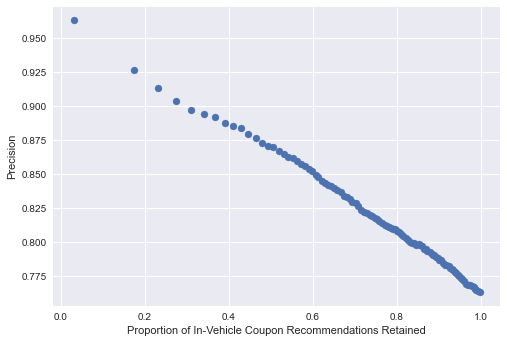

time: 101 ms (started: 2022-10-29 06:12:51 -07:00)


In [83]:
plt.scatter(data=df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results,
            x='row_count_percentage_in_vehicle_coupon_recommendation_retained_prediction_probability_boostrap_mean_confidence_interval_filtered', 
            y='precision')
plt.xlabel('Proportion of In-Vehicle Coupon Recommendations Retained')
plt.ylabel('Precision')

In [84]:
#recommending coupons to a smaller smaller percentage of our sample drivers yields a higher precision.

time: 191 µs (started: 2022-10-29 06:12:52 -07:00)


Text(0, 0.5, 'Precision')

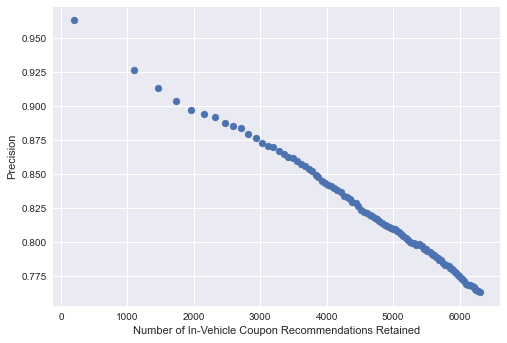

time: 82.4 ms (started: 2022-10-29 06:12:52 -07:00)


In [85]:
plt.scatter(data=df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results,
            x='row_count_prediction_probability_bootstrap_mean_confidence_interval_filtered_in_vehicle_coupon_recommendation_filtered', 
            y='precision')
plt.xlabel('Number of In-Vehicle Coupon Recommendations Retained')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

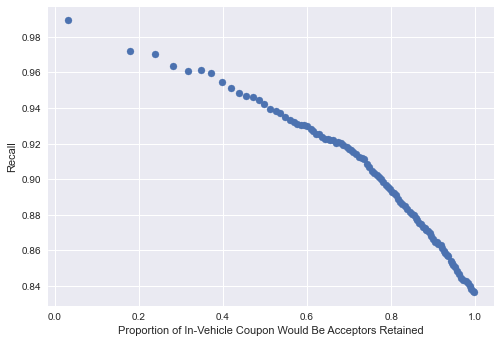

time: 77.8 ms (started: 2022-10-29 06:12:52 -07:00)


In [86]:
plt.scatter(data=df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results,
            x='row_count_percentage_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered', 
            y='recall')
plt.xlabel('Proportion of In-Vehicle Coupon Would Be Acceptors Retained')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

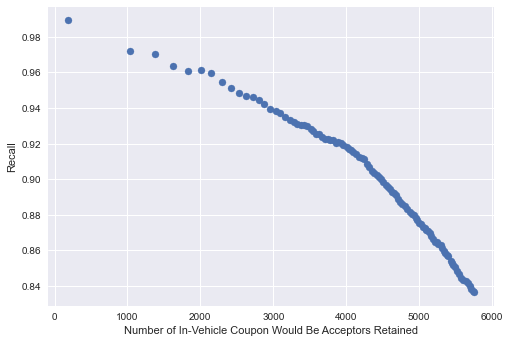

time: 75.7 ms (started: 2022-10-29 06:12:52 -07:00)


In [87]:
plt.scatter(data=df_prediction_probability_n_5_bootstrap_mean_confidence_interval_results,
            x='row_count_in_vehicle_coupon_accepted_retained_prediction_probability_bootstrap_mean_confidence_interval_filtered', 
            y='recall')
plt.xlabel('Number of In-Vehicle Coupon Would Be Acceptors Retained')
plt.ylabel('Recall')

In [88]:
#plot precision vs percentage of sample with data on

#but why do we care about the individuals who we don't want to recommend a coupon to???

time: 202 µs (started: 2022-10-29 06:12:52 -07:00)


In [89]:
#plot precision vs percentage of sample considered for in-vehicle coupon recommendation

time: 186 µs (started: 2022-10-29 06:12:52 -07:00)


In [90]:
# #gradient boosting


# gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=400, learning_rate=.8, max_depth=3, random_state=200)

# gradient_boosting_classifier.fit(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_train'], 
#                                  y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_train'])

# gradient_boosting_classifier.score(X=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['X_test'],
#                                    y=stratified_fold_number_X_train_X_test_Y_train_Y_test_collection['fold 0']['Y_test'])




time: 395 µs (started: 2022-10-29 06:12:52 -07:00)


## Get Gradient Boosting Classifier Stratified 5-Fold Grid Seach Cross Validation

In [91]:
#good split for gradient boosting classifier??? what does the learning curve say???

#get grid search stratified 5-fold cross validation results
models_readback = icr.return_saved_model_if_it_exists(filename=grid_search_models_filename_collection['gradient_boosting_classifier'])
if models_readback != None:
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = models_readback
else:
    gradient_boosting_classifier = GradientBoostingClassifier(random_state=200)
    param_grid = {'n_estimators' : [5, 50, 250, 500],
                  'max_depth' : [1, 3, 5, 7, 9],
                  'learning_rate' : [0.01, 0.1, 1, 10, 100],
                  'max_features' : [None],
                  'max_leaf_nodes' : [None],
                  'n_iter_no_change' : [None]
                 }

    #https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

    # Stratified 5-Fold object
    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = GridSearchCV(estimator=gradient_boosting_classifier, 
                                                                                               param_grid=param_grid, 
                                                                                               cv=StratifiedKFold_5_splits,
                                                                                               n_jobs=-1, 
                                                                                               verbose=0,
                                                                                               scoring=None,
                                                                                               pre_dispatch="2*n_jobs")

    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.fit(X=data_frame_collection['X_train'], 
                                                                                    y=data_frame_collection['Y_train'].loc[:, 'Y'],
                                                                                    groups=None)


    #save it
    stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model2(stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                             filename=grid_search_models_filename_collection['gradient_boosting_classifier'],
                                                                                                             add_compressed_file=False)
    
stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=200), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9], 'max_features': [None],
                         'max_leaf_nodes': [None],
                         'n_estimators': [5, 50, 250, 500],
                         'n_iter_no_change': [None]})

time: 21.1 ms (started: 2022-10-29 06:12:52 -07:00)


## Get Best Gradient Boosting Classifier by Score

In [92]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename_collection['gradient_boosting_classifier'])
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = model_readback
else:   
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier.build_datetime = datetime.datetime.now()    

    best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier = icr.save_and_return_model2(best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier, 
                                                                                                                  filename=model_filename,
                                                                                                                  add_compressed_file=False)
    
best_stratified_5_fold_grid_search_cross_validation_gradient_boosting_classifier


This file already exists.


RandomForestClassifier(bootstrap=False, min_samples_split=10, n_estimators=200,
                       random_state=200)

time: 43.8 ms (started: 2022-10-29 06:12:52 -07:00)


## Best Gradient Boosting Classifier Stratified 5-Fold Cross Validation Scores

In [93]:
#cross validate for best parameters
data_collection_readback = icr.return_processed_collection_if_it_exists(filename=model_cross_validation_results_collection['gradient_boosting_classifier'])
if data_collection_readback != None:
    best_gradient_boosting_classifier_stratified_5_fold_cross_validation_results = data_collection_readback
else:
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}

    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    gradient_boosting_classifier = GradientBoostingClassifier(learning_rate = 0.1, 
                                                              max_depth = 9, 
                                                              n_estimators = 250,
                                                              random_state=200,
                                                              max_features=None,
                                                              verbose=0,
                                                              max_leaf_nodes=None,
                                                              warm_start=False,
                                                              n_iter_no_change=None)

    best_gradient_boosting_classifier_stratified_5_fold_cross_validation_results = cross_validate(estimator=gradient_boosting_classifier, 
                                                                                                  X=data_frame_collection['X_train'], 
                                                                                                  y=data_frame_collection['Y_train'], 
                                                                                                  groups=None, 
                                                                                                  scoring=scoring, 
                                                                                                  cv=StratifiedKFold_5_splits, 
                                                                                                  n_jobs=None, verbose=0, 
                                                                                                  fit_params=None, 
                                                                                                  pre_dispatch='2*n_jobs', 
                                                                                                  return_train_score=False, 
                                                                                                  return_estimator=False, 
                                                                                                  error_score=np.nan)
    
    #save it
    best_gradient_boosting_classifier_stratified_5_fold_cross_validation_results = icr.save_and_return_collection(best_gradient_boosting_classifier_stratified_5_fold_cross_validation_results, 
                                                                                                                  filename=model_cross_validation_results_collection['gradient_boosting_classifier'])
    
    
model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier'] = best_gradient_boosting_classifier_stratified_5_fold_cross_validation_results
model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']

This file already exists


{'fit_time': array([13.76703   , 13.62460399, 13.70769572, 13.69708323, 13.69709206]),
 'score_time': array([0.02830291, 0.02727389, 0.02824616, 0.02719688, 0.02713394]),
 'test_accuracy': array([0.7546798 , 0.77044335, 0.76540168, 0.77378019, 0.76786594]),
 'test_precision': array([0.77152318, 0.78907563, 0.77650897, 0.78868552, 0.77814029]),
 'test_recall': array([0.80762565, 0.81369151, 0.82495667, 0.82220295, 0.82740676]),
 'test_f1_score': array([0.78916173, 0.80119454, 0.8       , 0.80509554, 0.80201765])}

time: 5.81 ms (started: 2022-10-29 06:12:52 -07:00)


In [94]:
print("model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_precision'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_precision'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_recall'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_recall'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_f1_score'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_f1_score'].mean()))
print("model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_accuracy'].mean(): " + str(model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_accuracy'].mean()))



model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_precision'].mean(): 0.7807867198183774
model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_recall'].mean(): 0.8191767087892184
model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_f1_score'].mean(): 0.799493892495359
model_stratified_5_fold_cross_validation_results_collection['best_gradient_boosting_classifier']['test_accuracy'].mean(): 0.766434191902148
time: 852 µs (started: 2022-10-29 06:12:52 -07:00)


## Get Learning Curve for Best Gradient Boosting Clasifier

In [95]:
#get learning curve

data_frame_readback = icr.return_processed_collection_if_it_exists(filename=learning_curve_results_collection['gradient_boosting_classifier'], parse_dates=False)

if type(data_frame_readback) == type(pd.DataFrame({})):
    df_learning_curve_results_best_gradient_boosting_classifier = data_frame_readback
else:
    best_gradient_boosting_classifier = GradientBoostingClassifier(learning_rate = 0.1, 
                                                                   max_depth = 9, 
                                                                   n_estimators = 250,
                                                                   random_state=200,
                                                                   max_features=None,
                                                                   verbose=0,
                                                                   max_leaf_nodes=None,
                                                                   warm_start=False,
                                                                   n_iter_no_change=None)

    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

    train_sizes_abs, train_scores_ndarray, test_scores_ndarray, fit_times_ndarray, score_times_ndarray = \
    learning_curve(estimator=best_gradient_boosting_classifier,
                   X=data_frame_collection['X_train'],
                   y=data_frame_collection['Y_train'],
                   train_sizes=np.linspace(0.1, 1.0, 5),
                   cv=StratifiedKFold_5_splits,
                   shuffle=False,
                   verbose=0,
                   scoring=None,
                   random_state=200,
                   return_times=True)


    df_learning_curve_results_best_gradient_boosting_classifier = pd.DataFrame([train_sizes_abs, train_scores_ndarray, test_scores_ndarray, fit_times_ndarray, score_times_ndarray])
    
    #save it
    df_learning_curve_results_best_gradient_boosting_classifier = icr.save_and_return_collection(df_learning_curve_results_best_gradient_boosting_classifier, 
                                                                                                 filename=learning_curve_results_collection['gradient_boosting_classifier'])

df_learning_curve_results_best_gradient_boosting_classifier


This file already exists


,0,1,2,3,4
0,811,2638,4464,6290,8117
1,"[1.0, 0.998766954377312, 0.998766954377312, 0.998766954377312, 0.998766954377312]","[0.9996209249431387, 0.9996209249431387, 0.9996209249431387, 0.9996209249431387, 0.9996209249431387]","[0.9993279569892473, 0.9995519713261649, 0.9995519713261649, 0.9995519713261649, 0.9995519713261649]","[0.9987281399046105, 0.9988871224165342, 0.9993640699523052, 0.9995230524642289, 0.9995230524642289]","[0.9985216212886534, 0.9986448195145989, 0.9990144141924356, 0.9990144141924356, 0.9990144141924356]"
2,"[0.674384236453202, 0.6783251231527093, 0.6663380975850173, 0.6688023656973878, 0.661409561360276]","[0.6960591133004926, 0.6970443349753694, 0.7116806308526368, 0.7141448989650074, 0.7171020206998522]","[0.7216748768472906, 0.7453201970443349, 0.7387875800887137, 0.736323311976343, 0.7338590438639724]","[0.7399014778325124, 0.7655172413793103, 0.7451946771808773, 0.7629374075899458, 0.7624445539674717]","[0.7546798029556651, 0.7704433497536946, 0.7678659438146871, 0.7762444553967471, 0.7673730901922129]"
3,"[2.1415390968322754, 2.065936803817749, 2.035154104232788, 2.0458240509033203, 2.0894856452941895]","[5.157454252243042, 5.188102960586548, 5.245374917984009, 5.605778932571411, 5.4618401527404785]","[9.912603855133057, 8.102813959121704, 8.157344102859497, 8.540005922317505, 8.34751296043396]","[12.988197088241577, 11.072697162628174, 10.984767198562622, 11.478716135025024, 10.939082145690918]","[14.330978155136108, 13.890865802764893, 13.908544063568115, 14.062664985656738, 13.640686750411987]"
4,"[0.02524280548095703, 0.02414107322692871, 0.023275136947631836, 0.022748231887817383, 0.024222135543823242]","[0.026392698287963867, 0.025515079498291016, 0.024856090545654297, 0.029532194137573242, 0.02517414093017578]","[0.02992701530456543, 0.025007009506225586, 0.02519989013671875, 0.026133060455322266, 0.03418231010437012]","[0.03050708770751953, 0.025539875030517578, 0.02539682388305664, 0.03186798095703125, 0.029514789581298828]","[0.026922941207885742, 0.024975061416625977, 0.025267839431762695, 0.02520012855529785, 0.025159358978271484]"


time: 14.3 ms (started: 2022-10-29 06:12:52 -07:00)


In [96]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, scoring=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True,)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    
    #^----save this data????

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,  alpha=0.1, color="r",)
    
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g",)
    
    axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    
    axes[0].plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    
    axes[0].legend(loc="best")
    
    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,  fit_times_mean + fit_times_std, alpha=0.1,)
    
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(fit_time_sorted, test_scores_mean_sorted - test_scores_std_sorted, test_scores_mean_sorted + test_scores_std_sorted, alpha=0.1,)
    
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

time: 2.05 ms (started: 2022-10-29 06:12:52 -07:00)


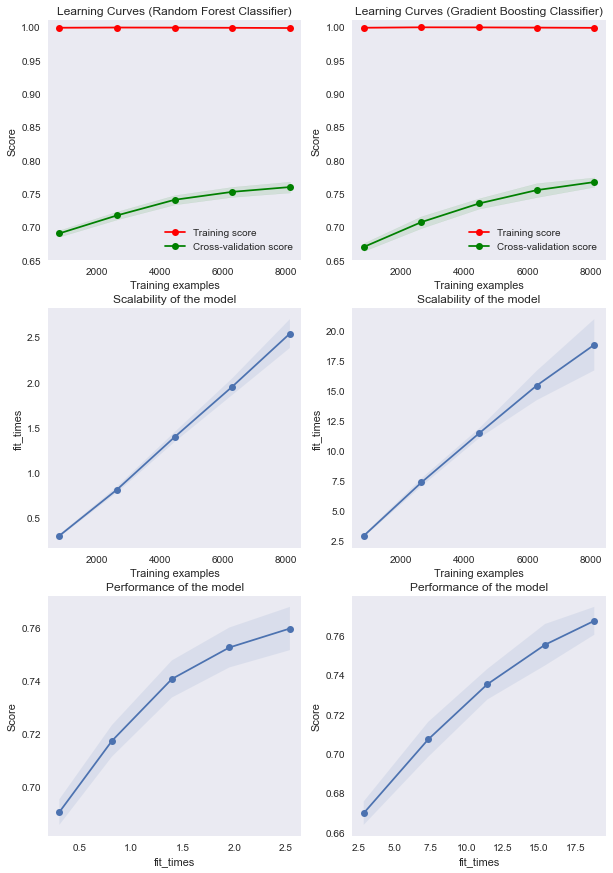

time: 1min 8s (started: 2022-10-29 06:17:19 -07:00)


In [104]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Random Forest Classifier)"

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
estimator = RandomForestClassifier(bootstrap=False, 
                                   max_depth=25, 
                                   min_samples_split=4, 
                                   n_estimators=200,
                                   random_state=200,
                                   min_samples_leaf=1,
                                   max_features='auto',
                                   criterion='gini',
                                   warm_start='False',)

plot_learning_curve(estimator, 
                    title, 
                    X=data_frame_collection['X_train'], 
                    y=data_frame_collection['Y_train'].loc[:, 'Y'], 
                    axes=axes[:, 0], 
                    ylim=(0.65, 1.01), 
                    cv=cv, 
                    n_jobs=4, 
                    scoring="accuracy")




title = r"Learning Curves (Gradient Boosting Classifier)"

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
estimator = GradientBoostingClassifier(learning_rate = 0.1, 
                                       max_depth = 9, 
                                       n_estimators = 250,
                                       random_state=200,
                                       max_features=None,
                                       verbose=0,
                                       max_leaf_nodes=None,
                                       warm_start=False,
                                       n_iter_no_change=None)


plot_learning_curve(estimator, 
                    title, 
                    X=data_frame_collection['X_train'], 
                    y=data_frame_collection['Y_train'].loc[:, 'Y'], 
                    axes=axes[:, 1], 
                    ylim=(0.65, 1.01), 
                    cv=cv, 
                    n_jobs=4)

plt.show()



#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [98]:
#ada boost

time: 309 µs (started: 2022-10-29 06:14:07 -07:00)


In [99]:
#will later translate to make in-vehicle coupon recommendation yes or no, in the case the prediction was to recommend a coupon.



time: 2.29 ms (started: 2022-10-29 06:14:07 -07:00)


In [100]:
#random forest classifier variance reduction???

time: 140 µs (started: 2022-10-29 06:14:07 -07:00)


In [101]:
data_frame_collection['Y_train'].loc[:, 'Y'].value_counts()

1    5768
0    4379
Name: Y, dtype: int64

time: 5.3 ms (started: 2022-10-29 06:14:07 -07:00)


In [102]:
#random forest classifier overfitting???

# Every ML algorithm with high complexity can overfit. However, the OP is asking whether an RF will not overfit when increasing the number of trees in the forest.

# In general, ensemble methods reduces the prediction variance to almost nothing, improving the accuracy of the ensemble. If we define the variance of the expected generalization error of an individual randomized model as:



# From here, the variance of the expected generalization error of an ensemble corresponds to:



# where p(x) is the Pearson’s correlation coefficient between the predictions of two randomized models trained on the same data from two independent seeds. If we increase the number of DT's in the RF, larger M, the variance of the ensemble decreases when ρ(x)<1. Therefore, the variance of an ensemble is strictly smaller than the variance of an individual model.

# In a nutshell, increasing the number of individual randomized models in an ensemble will never increase the generalization error.

#https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit


time: 547 µs (started: 2022-10-29 06:14:07 -07:00)


In [103]:
#convert grid search stratified 5-fold cross validation results to data frame

#keys from stratified_5_fold_grid_search_cross_validation.cv_results_.keys()
random_forest_classifier_grid_search_stratified_cross_validation_results_dictionary_keys = ['param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']

df_random_forest_classifier_grid_search_stratified_cross_validation_results = pd.DataFrame()
for key in random_forest_classifier_grid_search_stratified_cross_validation_results_dictionary_keys:
    
    df_random_forest_classifier_grid_search_stratified_cross_validation_results = \
    pd.concat([df_random_forest_classifier_grid_search_stratified_cross_validation_results,  pd.DataFrame(stratified_5_fold_grid_search_cross_validation.cv_results_[key])], axis=1)

df_random_forest_classifier_grid_search_stratified_cross_validation_results.columns = random_forest_classifier_grid_search_stratified_cross_validation_results_dictionary_keys
    
p(df_random_forest_classifier_grid_search_stratified_cross_validation_results)

NameError: name 'stratified_5_fold_grid_search_cross_validation' is not defined

time: 333 ms (started: 2022-10-29 06:14:07 -07:00)


In [ ]:
# #scatter plot of param_max_depth, param_min_samples_split, mean_test_score


# #get top 80 grid search stratified 5-fold cross validation results by accuracy
# df_random_forest_classifier_grid_search_stratified_cross_validation_results_top80 = \
# df_random_forest_classifier_grid_search_stratified_cross_validation_results.sort_values('mean_test_score', ascending=False)[0:80]
# p(df_random_forest_classifier_grid_search_stratified_cross_validation_results_top80)

# #plot scatter
# sns.set(rc={'figure.figsize':(15,12)})
# sns.scatterplot(data=df_random_forest_classifier_grid_search_stratified_cross_validation_results_top80, 
#                 x="param_max_depth", 
#                 y="param_min_samples_split", 
#                 hue="mean_test_score",
#                 s=300)

In [ ]:
#What percentage of random forest classifiers perform better with more trees vs less, i.e. 1000 vs 1200???


#sort columns of random forest classifier grid search stratitifed cross validation results
df_random_forest_classifier_grid_search_stratified_cross_validation_results = df_random_forest_classifier_grid_search_stratified_cross_validation_results.sort_values(['param_bootstrap', 'param_max_depth', 'param_min_samples_split', 
                                                                                         'param_n_estimators'])

#select columns
grid_search_results_select_columns = ['param_bootstrap', 'param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score']
grid_search_results_groupby_columns = ['param_bootstrap', 'param_max_depth', 'param_min_samples_split']

mean_test_score_diff_result = df_random_forest_classifier_grid_search_stratified_cross_validation_results.loc[:, grid_search_results_select_columns].groupby(grid_search_results_groupby_columns).diff()

twelve000_classifier_high_accuracy_rate = mean_test_score_diff_result.loc[mean_test_score_diff_result.loc[:, 'mean_test_score'] > 0, :].shape[0] / mean_test_score_diff_result.shape[0] * 2
print('1200 classifiers has a higher classification accuracy than 1000 classifiers at a rate of ' + str(round(twelve000_classifier_high_accuracy_rate,3)))

one000_classifier_high_accuracy_rate = mean_test_score_diff_result.loc[mean_test_score_diff_result.loc[:, 'mean_test_score'] < 0, :].shape[0] / mean_test_score_diff_result.shape[0] * 2
print('1200 classifiers has a lower classification accuracy than 1000 classifiers at a rate of ' + str(round(one000_classifier_high_accuracy_rate,3)))

print('Therefore, more classifier is expected to performed better than less more often than not.')

In [ ]:
#adding more rows of data increase the max_depth????

In [ ]:
#get feature importants plot

plt.subplots(figsize=(5, 12))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:50].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top 50 Feature Importances');

plt.savefig('../reports/figures/figure_random_forest_classifier_top_50_feature_importances_v' + filename_version + '.png', bbox_inches='tight', dpi=600)



In [ ]:
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_25_by_feature_importance = series_random_forest_classifier_feature_importances[0:25].index.to_list()

pl(column_name_list_random_forest_classifier_top_50_by_feature_importance)

In [ ]:
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

In [ ]:

column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
column_name_list_random_forest_classifier_top_25_by_feature_importance_target = column_name_list_random_forest_classifier_top_25_by_feature_importance + ['Y']
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance_target)

In [ ]:
df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['Y_train']], axis=1)
p(df_train)

In [ ]:
#correlation heatmap of top 50 features and target

df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr() #correlation type??

fig, ax = plt.subplots(figsize=(30, 24))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_50_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
#correlation heatmap of top 25 features and target

df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_25_by_feature_importance_target].corr() #correlation type??

fig, ax = plt.subplots(figsize=(15, 12))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 25 Features and Target', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_25_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
#categories of top 25 features???

pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

#coupon_venue_type - coupon venue type

#temperature - outside temperature

#expiration - time til expiration

#CoffeeHouse - coffee house visits per month

In [ ]:
#correlation heatmap of top features

df_corr = data_frame_collection['X_train'].loc[:, column_name_list_random_forest_classifier_top_25_by_feature_importance].corr()

fig, ax = plt.subplots(figsize=(15, 12))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 25 Features', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_25_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
#correlation heatmap of top features

df_corr = data_frame_collection['X_train'].loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance].corr()

fig, ax = plt.subplots(figsize=(35, 30))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 50 Features', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_50_v'+ filename_version +'.png', bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
#random forest classifier hyperparameters

#https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6

In [ ]:
#selecting number of base estimators, i.e. decision trees

#https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred

In [ ]:
#min_samples_split vs min_samples_leaf

#https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre

In [ ]:
#how to show correlation for feature categories and boolean target variable???

#explain at the feature indicator level or the muli-category feature level???



In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = (predictions == test_labels.loc[:, 'Y']).value_counts('True')
    return accuracy

grid_accuracy = evaluate(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, data_frame_collection['X_train'], data_frame_collection['Y_train'])
grid_accuracy

In [ ]:
df_target_predicted = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict(data_frame_collection['X_train'])

(df_target_predicted == Y_train.loc[:, 'Y']).value_counts('True')

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_train, df_target_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
#alternative ML model: adaboost

#https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725





In [ ]:
#AUC ROC

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

#import dataset from CSV file on Github
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv"
data = pd.read_csv(url)

#define the predictor variables and the response variable
X = data[['student', 'balance', 'income']]
y = data['default']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,Y_train)



#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

<font size="5"><a id='[Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Results]'>**Results**</a> </font>

In [ ]:
# grid_accuracy = evaluate(best_grid_cross_validation_random_forest_classifier, X_test, Y_test.loc[:, 'Y'])
# grid_accuracy

In [ ]:
# #get Y_test predicted and actual
# Y_test_predicted = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict(data_frame_collection['X_test'])
# Y_test_actual = data_frame_collection['Y_test'].loc[:, 'Y']


# #calculate recall score, precision score, and difference
# test_recall_score = recall_score(Y_test_actual, Y_test_predicted, average='binary')
# test_precision_score = precision_score(Y_test_actual, Y_test_predicted, average='binary')
# test_recall_score_test_precision_score_difference = (test_recall_score - test_precision_score)
# print('test_recall_score '+ str(round(test_recall_score, 5)) + ' is slightly better than test_precision_score ' + str(round(test_precision_score, 5)) + ' with difference of ' + str(round(test_recall_score_test_precision_score_difference, 5)) + '.')



In [ ]:
dir()

In [ ]:
# !conda install wordcloud

In [ ]:
# !pip install autoviz

In [ ]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()
# help(AV.AutoViz)

In [ ]:
# df = AV.AutoViz(os.path.join('..', 'data', 'raw', 'fraudTrain.csv'))

In [ ]:
# df = AV.AutoViz(os.path.join('..', 'data', 'raw', 'fraudTest.csv'))